In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from snorkel.labeling.model import LabelModel


### Explanation of the Code and Methods

#### First Code Block:

1. **Dataset Creation**: 
   Synthetic classification data is generated using `make_classification`. The datasets have configurable properties like the number of features, informative features, class separation, and class balance.

2. **Label Functions**:
   Probabilistic label functions are created using multivariate normal distributions. These functions assign labels based on the probability that a sample belongs to a particular class. If the probability exceeds a certain threshold, a label is assigned; otherwise, the function abstains from labeling.

   $$ \hat{y} = 
   \begin{cases} 
   \text{positive\_label}, & \text{if } p(x) > \text{threshold} \\
   -1, & \text{if \ \text{abstain\_prob}} \\
   1 - \text{positive\_label}, & \text{otherwise}
   \end{cases} $$

3. **Snorkel Model**:
   The Snorkel model aggregates noisy labels from multiple weak labelers using expectation-maximization (EM). It learns weights for each label function and predicts the most likely label.
   
   $$ \hat{y} = \arg \max_y P(y \mid \text{label functions}) $$

4. **FA (Factor Analysis) Model**:
   A neural network model combines feature embeddings and label function outputs. The embeddings are processed through separate layers, concatenated, and classified using a fully connected layer.
   
   $$ \hat{y} = \text{softmax}(W_c [h_f; h_{lf}] + b_c) $$

5. **Factor Analysis**:
   Dimensionality reduction is performed by factor analysis, followed by logistic regression on the reduced features. Factor analysis models the data as a linear combination of latent factors and Gaussian noise.
   
   Let $X$ be a $p$-dimensional random vector with mean $\mu$ and covariance matrix $\Sigma$. The factor analysis model is:
   
   $$ X - \mu = LF + \epsilon $$
   
   Where:
   - $L$ is a $p \times k$ matrix of factor loadings
   - $F$ is a $k$-dimensional vector of latent factors (where $k < p$)
   - $\epsilon$ is a $p$-dimensional vector of error terms
   

---

#### Second Code Block: GPLVM-SVGP & VI-FA

1. **GPLVM-SVGP**:
   This method combines Gaussian Process Latent Variable Models (GPLVM) with Sparse Variational Gaussian Processes (SVGP). It models the latent space of observed data with a Gaussian process prior and approximates the posterior distribution over latent variables using variational inference.
   
   $$ \text{ELBO} = \mathbb{E}_{q(Z)}[\log p(Y \mid Z)] - D_{KL}[q(Z) \mid\mid p(Z)] $$

2. **VI-FA**:
   Variational Inference Factor Analysis (VI-FA) uses Bayesian techniques to estimate the posterior distribution of latent factors. The loss function combines the likelihood of the data given the latent factors and the KL divergence between the approximate and true posterior distributions.
   
   $$ D_{KL}[q(\theta) \mid\mid p(\theta)] $$

   where $\theta$ are the latent factors.

---

#### Third Code Block: Refinements

1. **Class Weights**:
   To handle imbalanced datasets, class weights are introduced into the loss functions for both the VI-FA and GPLVM models. This ensures that the models don't become biased towards the majority class.

2. **Posterior Inference**:
   In the GPLVM-SVGP model, posterior inference is improved by adding auxiliary regression models, which map observed data back into the latent space for test-time predictions. This makes the model more robust when predicting new data points.

3. **KL-Divergence for Latent Factors**:
   The KL-divergence term is added in VI-FA to regularize the latent variables and ensure that the approximate posterior is close to the true posterior distribution. This improves the model's generalization by balancing data likelihood and model complexity.


In [ ]:

# Function to create datasets
def create_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_classes=n_classes, 
                               n_informative=n_informative, n_redundant=0, n_repeated=0,
                               class_sep=class_sep, weights=weights, random_state=random_state)
    return X, y

# Function to create label functions
def create_label_functions(df, n_functions, abstain_prob=0.3):
    features = df.drop('label', axis=1).columns
    n_features = len(features)
    
    def label_function_factory(mean, cov, threshold, positive_label):
        def lf(x):
            prob = multivariate_normal.pdf(x[features], mean=mean, cov=cov)
            if prob > threshold:
                return positive_label
            elif np.random.random() < abstain_prob:
                return -1  # Abstain
            else:
                return 1 - positive_label  # Return the opposite label
        return lf
    
    label_functions = []
    for _ in range(n_functions):
        mean = np.random.rand(n_features)
        cov = np.eye(n_features) * np.random.uniform(0.5, 2)
        threshold = np.random.uniform(0.1, 0.9)
        positive_label = np.random.choice([0, 1])
        lf = label_function_factory(mean, cov, threshold, positive_label)
        label_functions.append(lf)
    
    return label_functions

# Function to apply label functions
def apply_label_functions(df, lfs):
    results = []
    for lf in lfs:
        results.append(df.apply(lf, axis=1))
    return pd.DataFrame(results).T

# Snorkel model
def train_snorkel(L_train, L_test, y_test):
    L_train = L_train.values if hasattr(L_train, 'values') else L_train
    L_test = L_test.values if hasattr(L_test, 'values') else L_test
    L_train = L_train.astype(int)
    L_test = L_test.astype(int)
    label_model = LabelModel(cardinality=len(np.unique(y_test)), verbose=True)
    label_model.fit(L_train, n_epochs=500, log_freq=100, seed=123)
    preds_test = label_model.predict(L_test)
    return preds_test

# FA model
class FAModel(nn.Module):
    def __init__(self, n_features, n_lfs, n_classes):
        super(FAModel, self).__init__()
        self.feature_encoder = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.lf_encoder = nn.Sequential(
            nn.Linear(n_lfs, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(48, n_classes)
        
    def forward(self, features, lf_outputs):
        feature_emb = self.feature_encoder(features)
        lf_emb = self.lf_encoder(lf_outputs)
        combined = torch.cat((feature_emb, lf_emb), dim=1)
        return self.classifier(combined)

def train_fa_model(X_train, L_train, X_test, L_test, y_test, n_epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_classes = len(np.unique(y_test))
    model = FAModel(X_train.shape[1], L_train.shape[1], n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    L_train_processed = np.where(L_train >= 0, L_train, 0)
    L_test_processed = np.where(L_test >= 0, L_test, 0)
    y_train = np.apply_along_axis(lambda x: np.bincount(x[x != 0]).argmax() if np.any(x != 0) else 0, axis=1, arr=L_train_processed)
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(L_train_processed), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for batch_features, batch_lfs, batch_labels in train_loader:
            batch_features, batch_lfs, batch_labels = batch_features.to(device), batch_lfs.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features, batch_lfs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.FloatTensor(X_test).to(device), torch.FloatTensor(L_test_processed).to(device))
        test_preds = test_outputs.argmax(dim=1).cpu().numpy()
    return test_preds, losses

# Other FactorAnalysis model
def train_factor_analysis(X_train, y_train, X_test, n_factors=5):
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(X_train)
    X_train_transformed = fa.transform(X_train)
    X_test_transformed = fa.transform(X_test)
    
    # Use a simple classifier on top of the factor analysis
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_transformed, y_train)
    
    return clf.predict(X_test_transformed)

# GPLVM-SVGP model
class GPLVM_SVGP:
    def __init__(self, Y, X_init, num_inducing, latent_dim, num_classes):
        self.num_data, self.num_lfs = Y.shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.X = tf.Variable(X_init, dtype=tf.float64)
        Z = np.random.randn(num_inducing, latent_dim)
        kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(latent_dim))
        inv_link = gpflow.likelihoods.RobustMax(num_classes)
        likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=inv_link)
        self.model = gpflow.models.SVGP(kernel, likelihood, inducing_variable=Z, num_data=self.num_data)
        
    def optimize(self, Y, num_iterations=1000, learning_rate=0.01):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        @tf.function
        def optimization_step():
            with tf.GradientTape() as tape:
                tape.watch(self.X)
                loss = -self.model.elbo((self.X, Y))
            trainable_vars = list(self.model.trainable_variables)
            grads = tape.gradient(loss, [self.X] + trainable_vars)
            optimizer.apply_gradients(zip(grads, [self.X] + trainable_vars))
            return loss
        losses = []
        for i in range(num_iterations):
            loss = optimization_step()
            losses.append(loss.numpy())
        return losses
        
    def predict(self, X_new):
        return self.model.predict_y(X_new)[0]

def train_gplvm_svgp(L_train, L_test, y_test, latent_dim=2, num_inducing=50, num_iterations=250):
    L_train_processed = np.where(L_train >= 0, L_train, 0)
    L_test_processed = np.where(L_test >= 0, L_test, 0)
    scaler = StandardScaler()
    L_train_scaled = scaler.fit_transform(L_train_processed)
    L_test_scaled = scaler.transform(L_test_processed)
    y_train = np.apply_along_axis(lambda x: np.bincount(x[x != 0]).argmax() if np.any(x != 0) else 0, axis=1, arr=L_train_processed)
    num_classes = len(np.unique(y_test))
    X_init = PCA(n_components=latent_dim).fit_transform(L_train_scaled)
    model = GPLVM_SVGP(L_train_scaled, X_init, num_inducing, latent_dim, num_classes)
    losses = model.optimize(y_train, num_iterations)
    X_test_init = PCA(n_components=latent_dim).fit_transform(L_test_scaled)
    preds_test = model.predict(X_test_init)
    preds_test = np.argmax(preds_test, axis=1)
    return preds_test, losses

# VI-FA model
class VI_FA(tf.Module):
    def __init__(self, n_features, n_factors, n_classes):
        super(VI_FA, self).__init__()
        self.n_features = n_features
        self.n_factors = n_factors
        self.n_classes = n_classes
        self.q_w_mu = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_w_rho = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_b_mu = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.q_b_rho = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.beta = tf.Variable(tf.random.normal([n_factors, n_classes], dtype=tf.float32))
    
    def sample_gaussian(self, mu, rho):
        epsilon = tf.random.normal(mu.shape, dtype=tf.float32)
        return mu + tf.math.softplus(rho) * epsilon
    
    @tf.function
    def log_likelihood(self, x, y):
        w_sample = self.sample_gaussian(self.q_w_mu, self.q_w_rho)
        b_sample = self.sample_gaussian(self.q_b_mu, self.q_b_rho)
        logits = tf.matmul(tf.matmul(x, w_sample) + b_sample, self.beta)
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    
    @tf.function
    def kl_divergence(self):
        kl_w = 0.5 * tf.reduce_sum(tf.square(self.q_w_mu) + tf.square(tf.math.softplus(self.q_w_rho)) - 2 * tf.math.log(tf.math.softplus(self.q_w_rho)) - 1)
        kl_b = 0.5 * tf.reduce_sum(tf.square(self.q_b_mu) + tf.square(tf.math.softplus(self.q_b_rho)) - 2 * tf.math.log(tf.math.softplus(self.q_b_rho)) - 1)
        return kl_w + kl_b
    
    @tf.function
    def compute_loss(self, x, y):
        return self.log_likelihood(x, y) + self.kl_divergence()
    
    def fit(self, x, y, num_iterations=1000, learning_rate=0.01, batch_size=32):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1000).batch(batch_size)
        @tf.function
        def train_step(x_batch, y_batch):
            with tf.GradientTape() as tape:
                loss = self.compute_loss(x_batch, y_batch)
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            return loss
        losses = []
        for i in range(num_iterations):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in dataset:
                loss = train_step(x_batch, y_batch)
                total_loss += loss
                num_batches += 1
            avg_loss = total_loss / num_batches
            losses.append(avg_loss.numpy())
        return losses
    
    def predict(self, x):
        w_mean = self.q_w_mu
        b_mean = self.q_b_mu
        logits = tf.matmul(tf.matmul(x, w_mean) + b_mean, self.beta)
        return tf.argmax(tf.nn.softmax(logits), axis=1)

def train_vi_fa(L_train, L_test, y_train, y_test, n_factors=5, num_iterations=250):
    L_train_processed = np.where(L_train == -1, 0, L_train).astype(np.float32)
    L_test_processed = np.where(L_test == -1, 0, L_test).astype(np.float32)
    n_features = L_train.shape[1]
    n_classes = len(np.unique(y_train))
    y_train_onehot = tf.one_hot(y_train, depth=n_classes).numpy().astype(np.float32)
    model = VI_FA(n_features, n_factors, n_classes)
    losses = model.fit(L_train_processed, y_train_onehot, num_iterations=num_iterations)
    preds_test = model.predict(L_test_processed).numpy()
    return preds_test, losses

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, f1, f2, cm

# Function to create and process datasets
def create_and_process_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state):
    X, y = create_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state)
    df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    df['label'] = y
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=random_state)
    lfs = create_label_functions(train_df, n_functions=5)
    train_labels = apply_label_functions(train_df, lfs)
    test_labels = apply_label_functions(test_df, lfs)
    return train_df, test_df, train_labels, test_labels

# Main execution
def main():
    # Define dataset parameters
    datasets = [
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 1.0, 'weights': [0.5, 0.5]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 1.0, 'weights': [0.7, 0.3]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 1.0, 'weights': [0.9, 0.1]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.5, 0.5]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.7, 0.3]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.9, 0.1]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.5, 0.5]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.7, 0.3]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.9, 0.1]},
    #     {'n_samples': 1000, 'n_features': 20, 'n_classes': 3, 'n_informative': 5, 'class_sep': 1.0, 'weights': [0.4, 0.3, 0.3]},
    #     {'n_samples': 1000, 'n_features': 20, 'n_classes': 3, 'n_informative': 5, 'class_sep': 1.2, 'weights': [0.6, 0.2, 0.2]},
    #     {'n_samples': 1000, 'n_features': 20, 'n_classes': 3, 'n_informative': 5, 'class_sep': 1.5, 'weights': [0.8, 0.1, 0.1]},
    #     {'n_samples': 1000, 'n_features': 25, 'n_classes': 4, 'n_informative': 6, 'class_sep': 1.0, 'weights': [0.3, 0.3, 0.2, 0.2]},
    #     {'n_samples': 1000, 'n_features': 25, 'n_classes': 4, 'n_informative': 6, 'class_sep': 1.2, 'weights': [0.5, 0.2, 0.2, 0.1]},
    #     {'n_samples': 1000, 'n_features': 25, 'n_classes': 4, 'n_informative': 6, 'class_sep': 1.5, 'weights': [0.7, 0.1, 0.1, 0.1]},
    ]
    results = []

    for i, dataset_params in enumerate(datasets):
        print(f"Processing dataset {i+1}")
        train_df, test_df, train_labels, test_labels = create_and_process_dataset(**dataset_params, random_state=42)

        # Snorkel
        snorkel_preds = train_snorkel(train_labels, test_labels, test_df['label'])
        snorkel_metrics = evaluate_model(test_df['label'], snorkel_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'Snorkel', **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], snorkel_metrics))})

        # FA Model
        fa_preds, fa_losses = train_fa_model(train_df.drop('label', axis=1).values, train_labels.values, 
                                             test_df.drop('label', axis=1).values, test_labels.values, 
                                             test_df['label'].values)
        fa_metrics = evaluate_model(test_df['label'], fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'FA Model', 'Loss': fa_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], fa_metrics))})
        
        # FactorAnalysis
        fa_preds = train_factor_analysis(train_df.drop('label', axis=1).values, train_df['label'].values, 
                                         test_df.drop('label', axis=1).values)
        fa_metrics = evaluate_model(test_df['label'], fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'FactorAnalysis', **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], fa_metrics))})

        # GPLVM-SVGP
        gplvm_preds, gplvm_losses = train_gplvm_svgp(train_labels.values, test_labels.values, test_df['label'].values)
        gplvm_metrics = evaluate_model(test_df['label'], gplvm_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'GPLVM-SVGP', 'Loss': gplvm_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], gplvm_metrics))})

        # VI-FA
        vi_fa_preds, vi_fa_losses = train_vi_fa(train_labels.values, test_labels.values, train_df['label'].values, test_df['label'].values)
        vi_fa_metrics = evaluate_model(test_df['label'], vi_fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'VI-FA', 'Loss': vi_fa_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], vi_fa_metrics))})

    return results


In [ ]:

# Run the main function
results = main()

# Create a DataFrame from the results
df_results = pd.DataFrame(results)


In [8]:
# Modified function to plot loss curves
def plot_loss_curves(df_results):
    models_with_loss = df_results[df_results['Loss'].notna()]['Model'].unique()
    n_models = len(models_with_loss)
    
    if n_models == 0:
        print("No models with loss data to plot.")
        return
    
    fig, axes = plt.subplots(n_models, 1, figsize=(15, 5*n_models))
    if n_models == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, model in enumerate(models_with_loss):
        for dataset in df_results['Dataset'].unique():
            model_data = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == model)]
            if not model_data.empty and 'Loss' in model_data.columns:
                axes[i].plot(model_data['Loss'].values[0], label=dataset)
        axes[i].set_title(f'{model} Loss Curves')
        axes[i].set_xlabel('Iterations')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

# Modified function to plot confusion matrices
def plot_confusion_matrices(df_results):
    n_datasets = df_results['Dataset'].nunique()
    n_models = df_results['Model'].nunique()
    
    fig, axes = plt.subplots(n_datasets, n_models, figsize=(5*n_models, 5*n_datasets))
    
    for i, dataset in enumerate(df_results['Dataset'].unique()):
        for j, model in enumerate(df_results['Model'].unique()):
            cm = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == model)]['CM'].values[0]
            ax = axes[i, j] if n_datasets > 1 else axes[j]
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
            ax.set_title(f'{dataset} - {model}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

# Modified function to plot model comparison
def plot_model_comparison(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_datasets = df_results['Dataset'].nunique()
    n_models = df_results['Model'].nunique()
    
    fig, axes = plt.subplots(n_datasets, 1, figsize=(5*n_models, 5*n_datasets))
    if n_datasets == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, dataset in enumerate(df_results['Dataset'].unique()):
        data = df_results[df_results['Dataset'] == dataset]
        x = np.arange(n_models)
        width = 0.25
        
        for j, metric in enumerate(metrics):
            axes[i].bar(x + j*width, data[metric], width, label=metric)
        
        axes[i].set_ylabel('Score')
        axes[i].set_title(dataset)
        axes[i].set_xticks(x + width)
        axes[i].set_xticklabels(data['Model'], rotation=45)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Modified function to plot metrics with datasets as hues
def plot_metrics_by_model(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, metric in enumerate(metrics):
        sns.barplot(x='Model', y=metric, hue='Dataset', data=df_results, ax=axes[i])
        axes[i].set_title(f'{metric} by Model')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

# Modified function to plot metrics with models as hues
def plot_metrics_by_dataset(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, metric in enumerate(metrics):
        sns.barplot(x='Dataset', y=metric, hue='Model', data=df_results, ax=axes[i])
        axes[i].set_title(f'{metric} by Dataset')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

# Function to create a summary table
def create_summary_table(df_results):
    summary = df_results.groupby(['Dataset', 'Model'])[['Accuracy', 'F1', 'F2']].mean().reset_index()
    summary_table = summary.pivot(index='Dataset', columns='Model', values=['Accuracy', 'F1', 'F2'])
    return summary_table

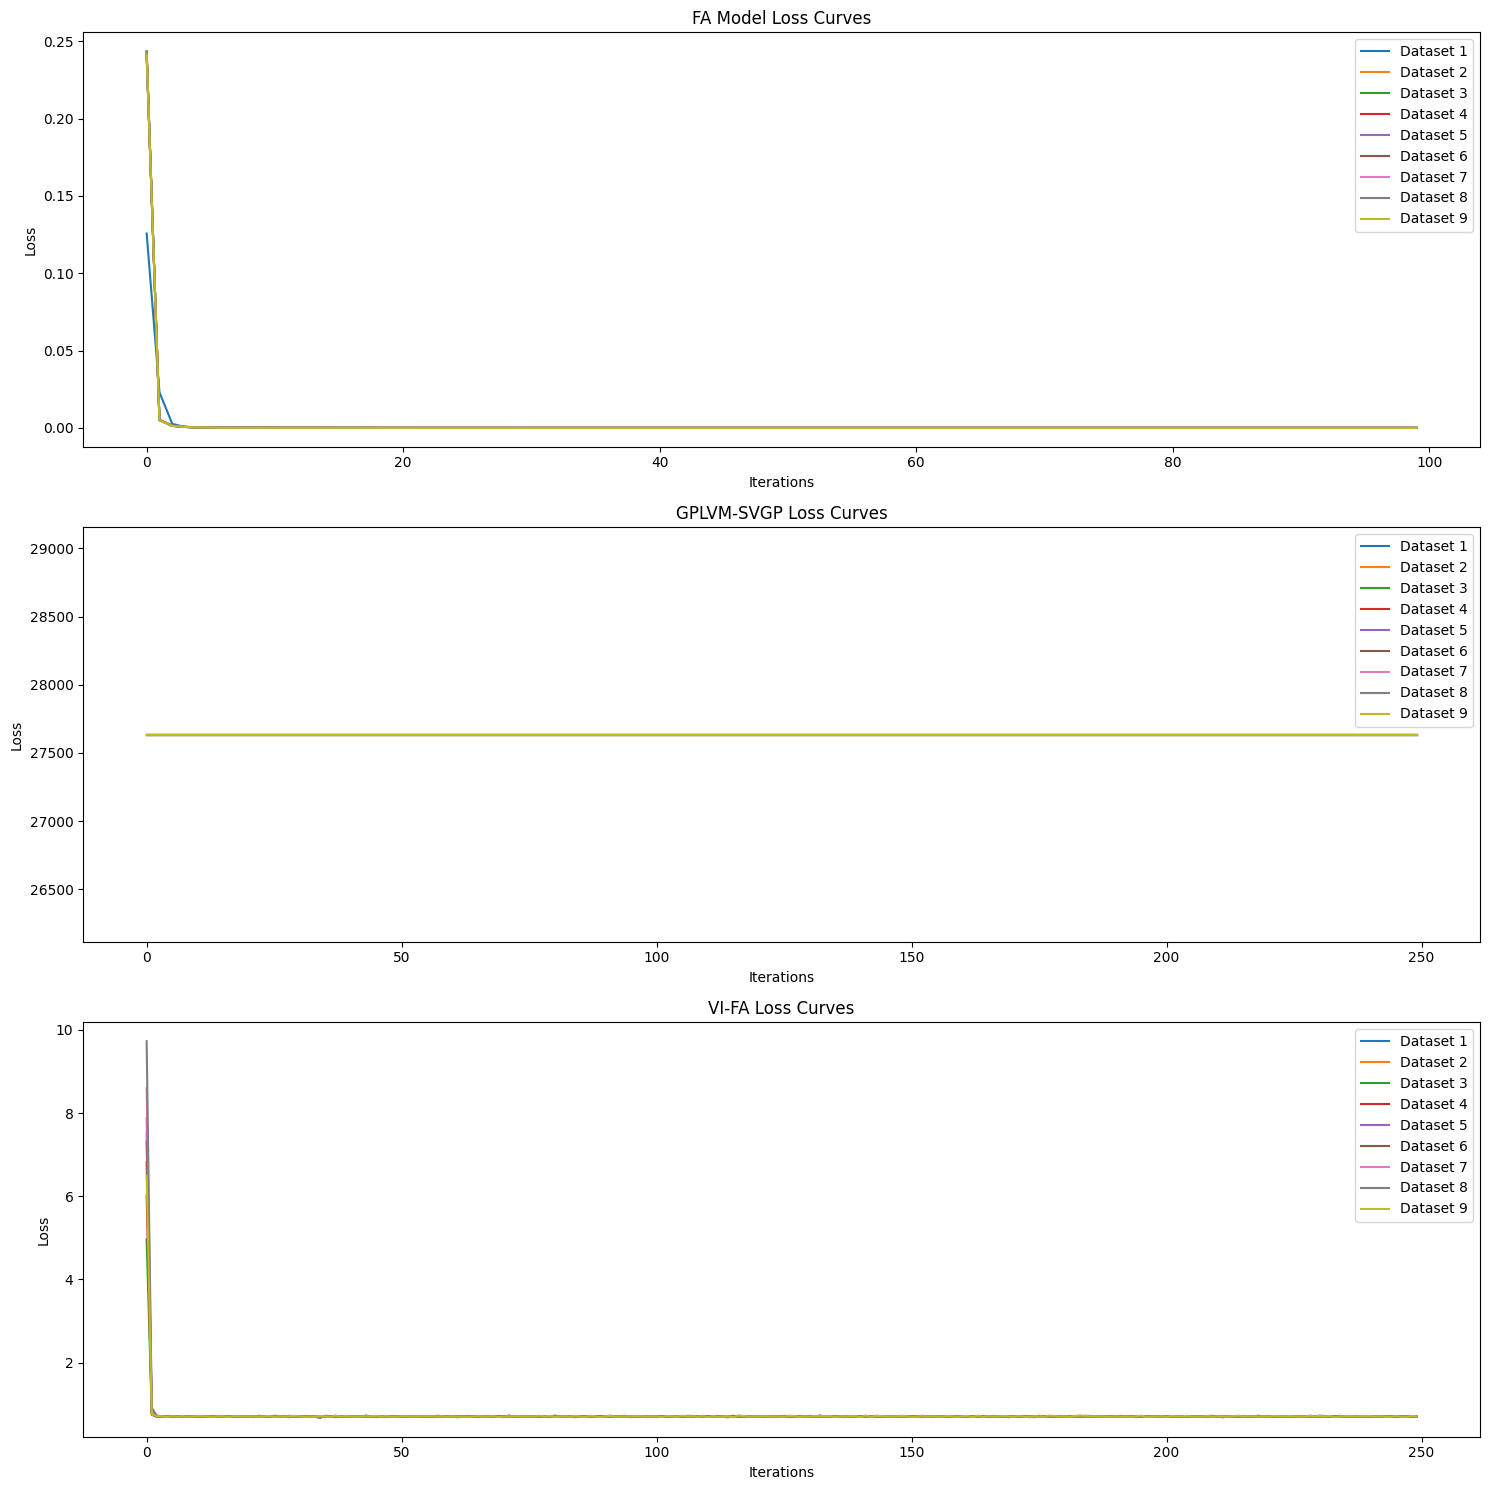

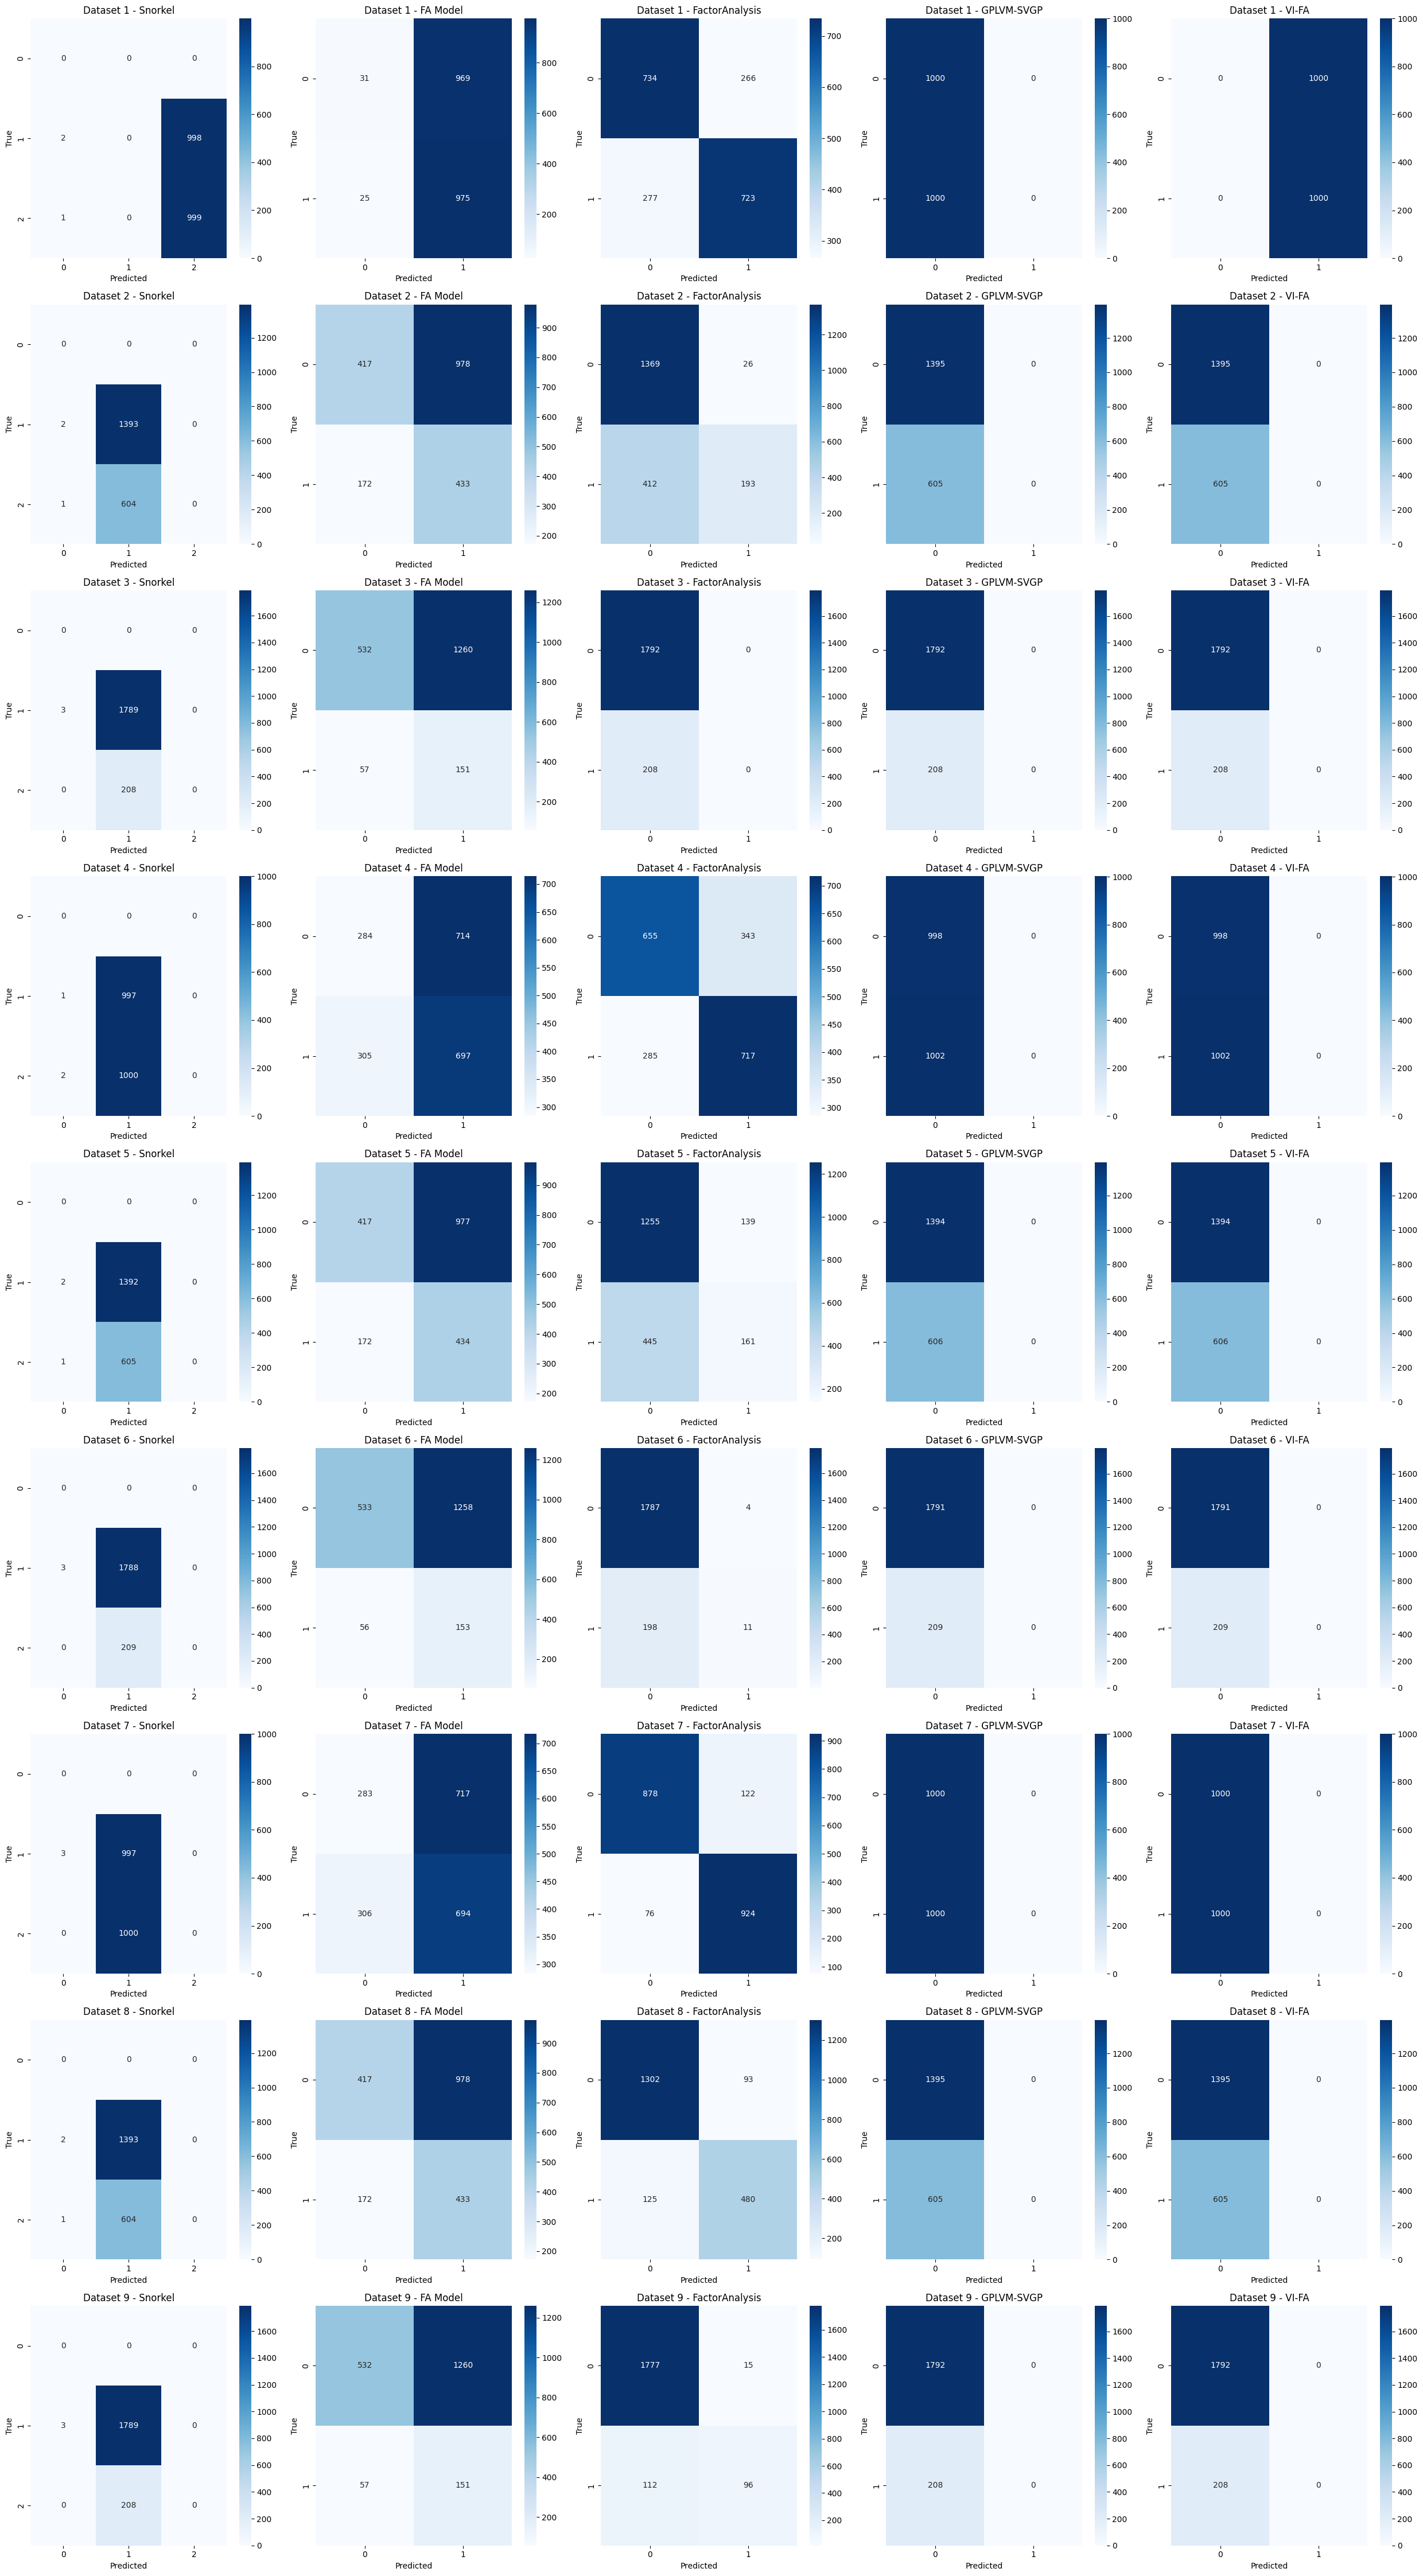

Summary Table:
          Accuracy                                                  F1  \
Model     FA Model FactorAnalysis GPLVM-SVGP Snorkel   VI-FA  FA Model   
Dataset                                                                  
Dataset 1   0.5030         0.7285     0.5000  0.4995  0.5000  0.360538   
Dataset 2   0.4250         0.7810     0.6975  0.6965  0.6975  0.423146   
Dataset 3   0.3415         0.8960     0.8960  0.8945  0.8960  0.419796   
Dataset 4   0.4905         0.6860     0.4990  0.4985  0.4990  0.468026   
Dataset 5   0.4255         0.7080     0.6970  0.6960  0.6970  0.423534   
Dataset 6   0.3430         0.8990     0.8955  0.8940  0.8955  0.420833   
Dataset 7   0.4885         0.9010     0.5000  0.4985  0.5000  0.465947   
Dataset 8   0.4250         0.8910     0.6975  0.6965  0.6975  0.423146   
Dataset 9   0.3415         0.9365     0.8960  0.8945  0.8960  0.419796   

                                                               F2  \
Model     FactorAnalysis GP

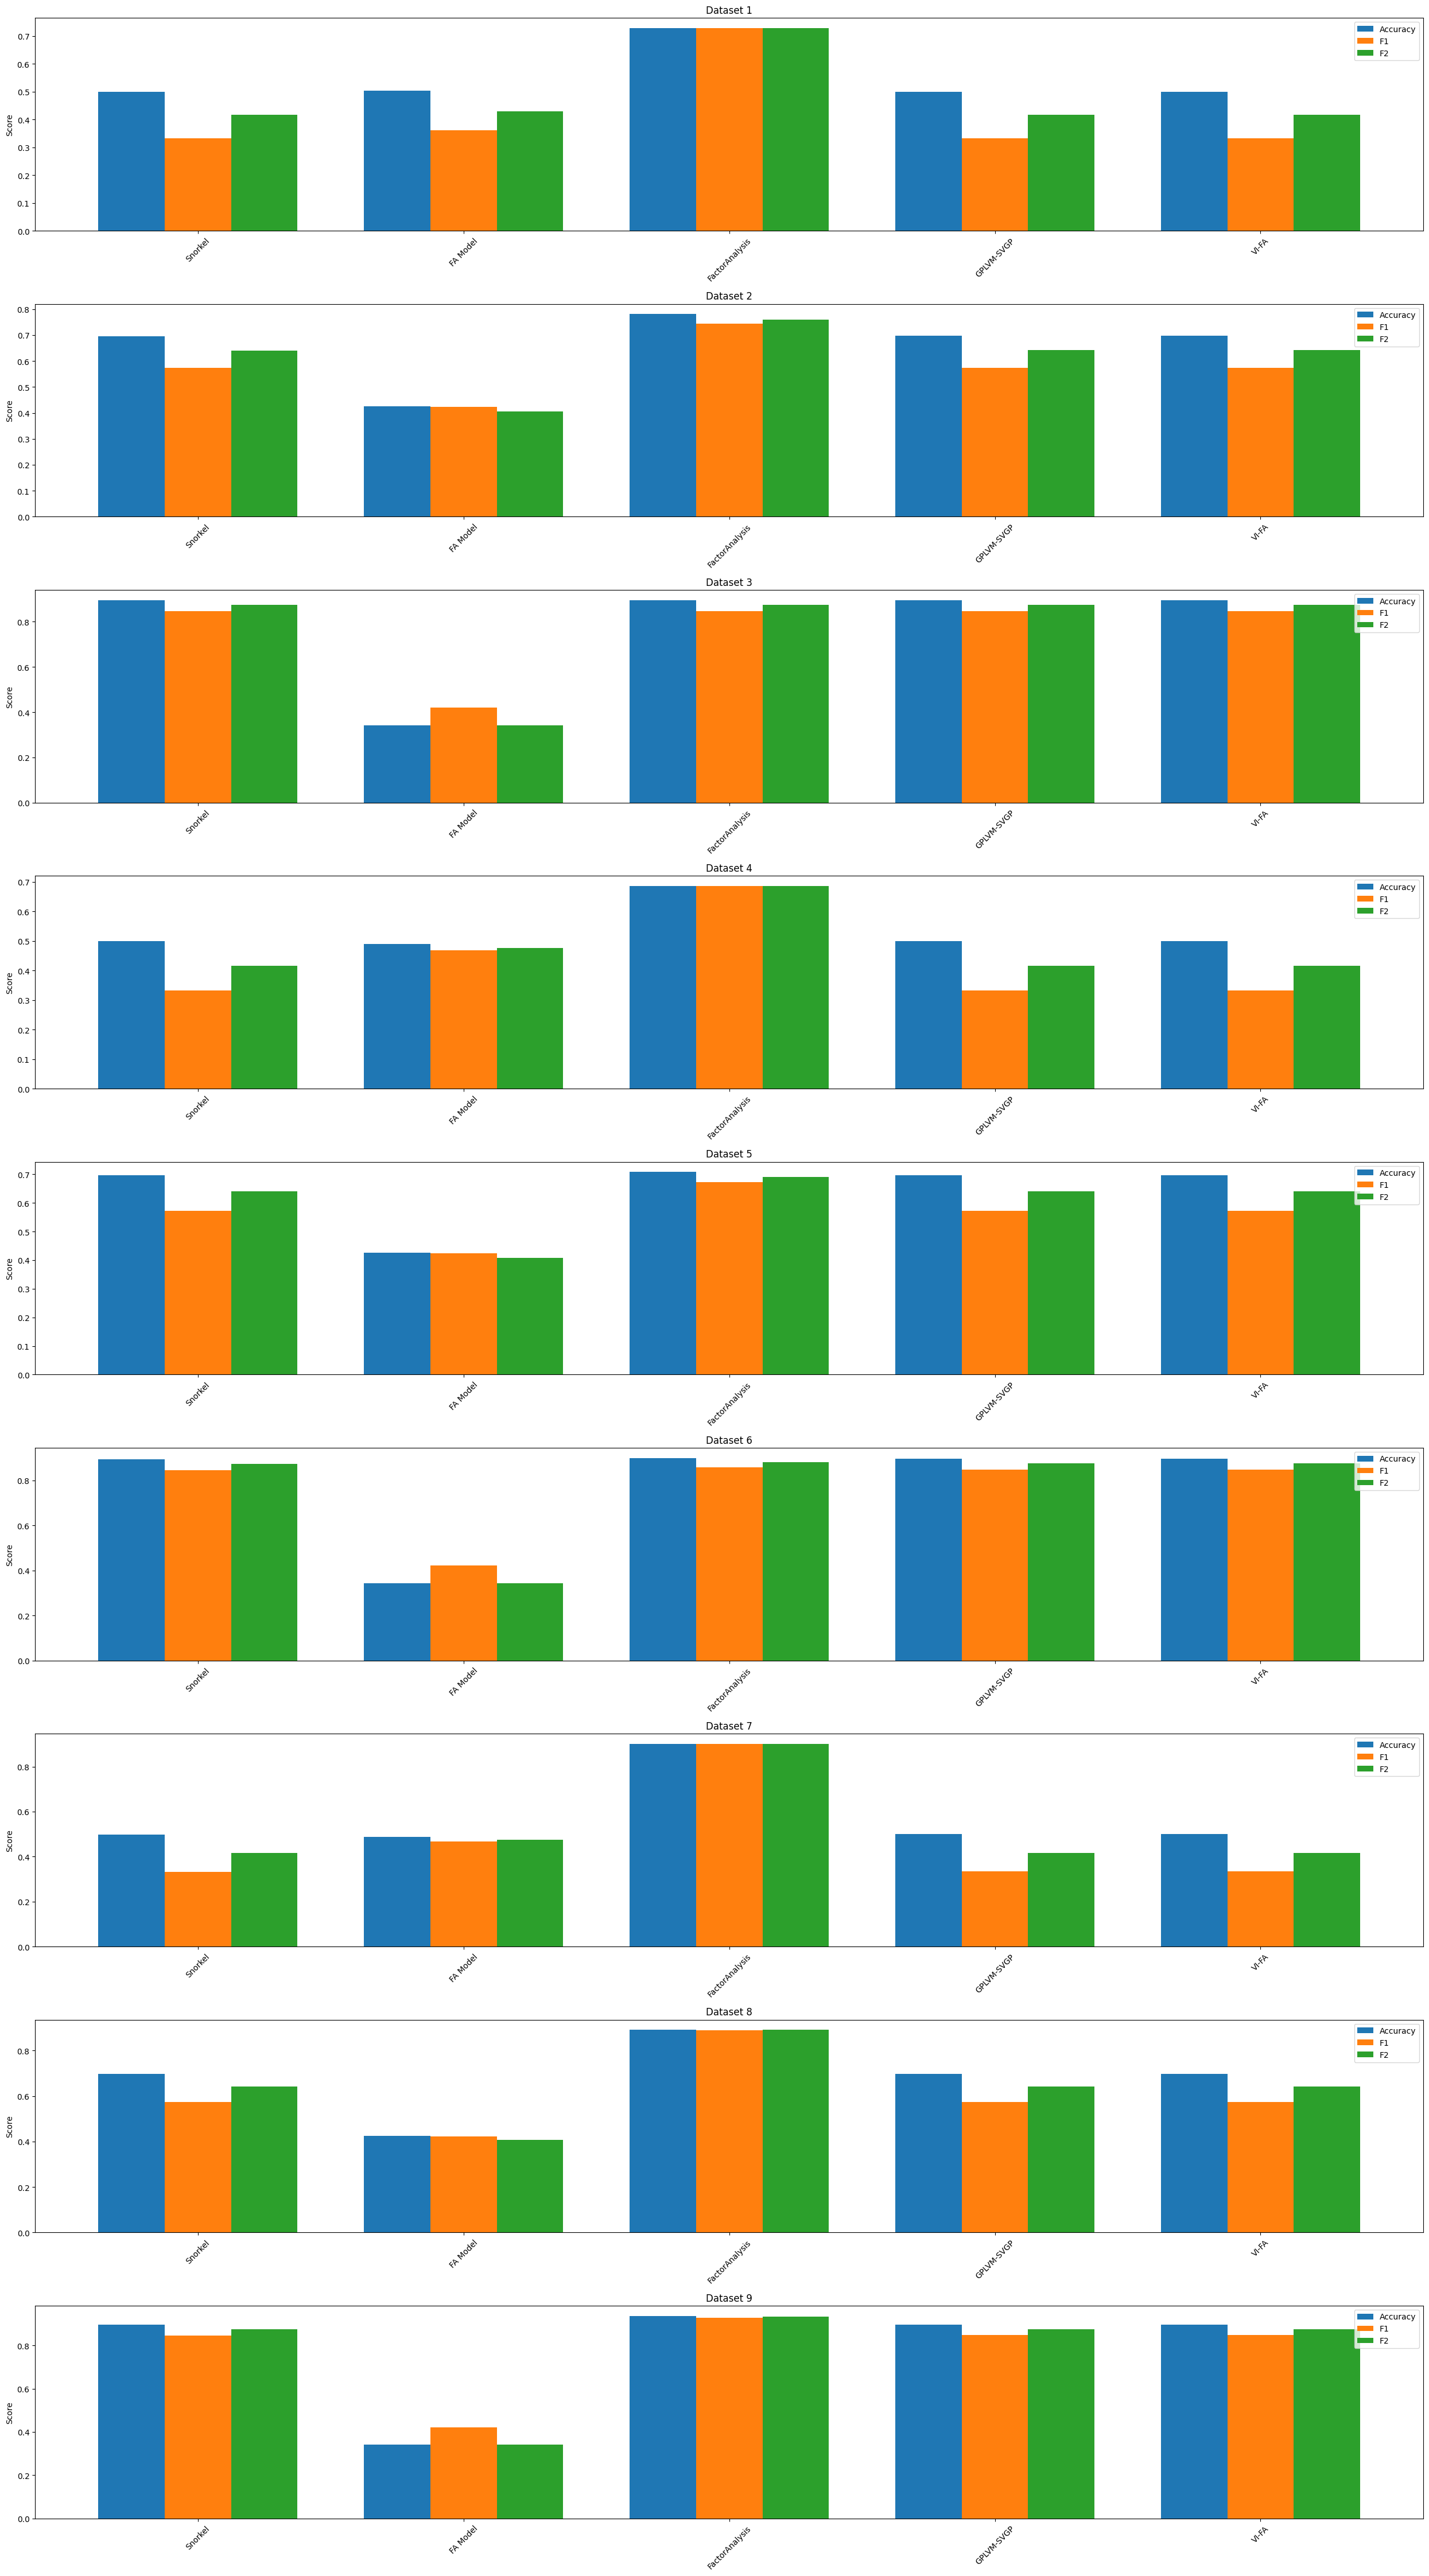

C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


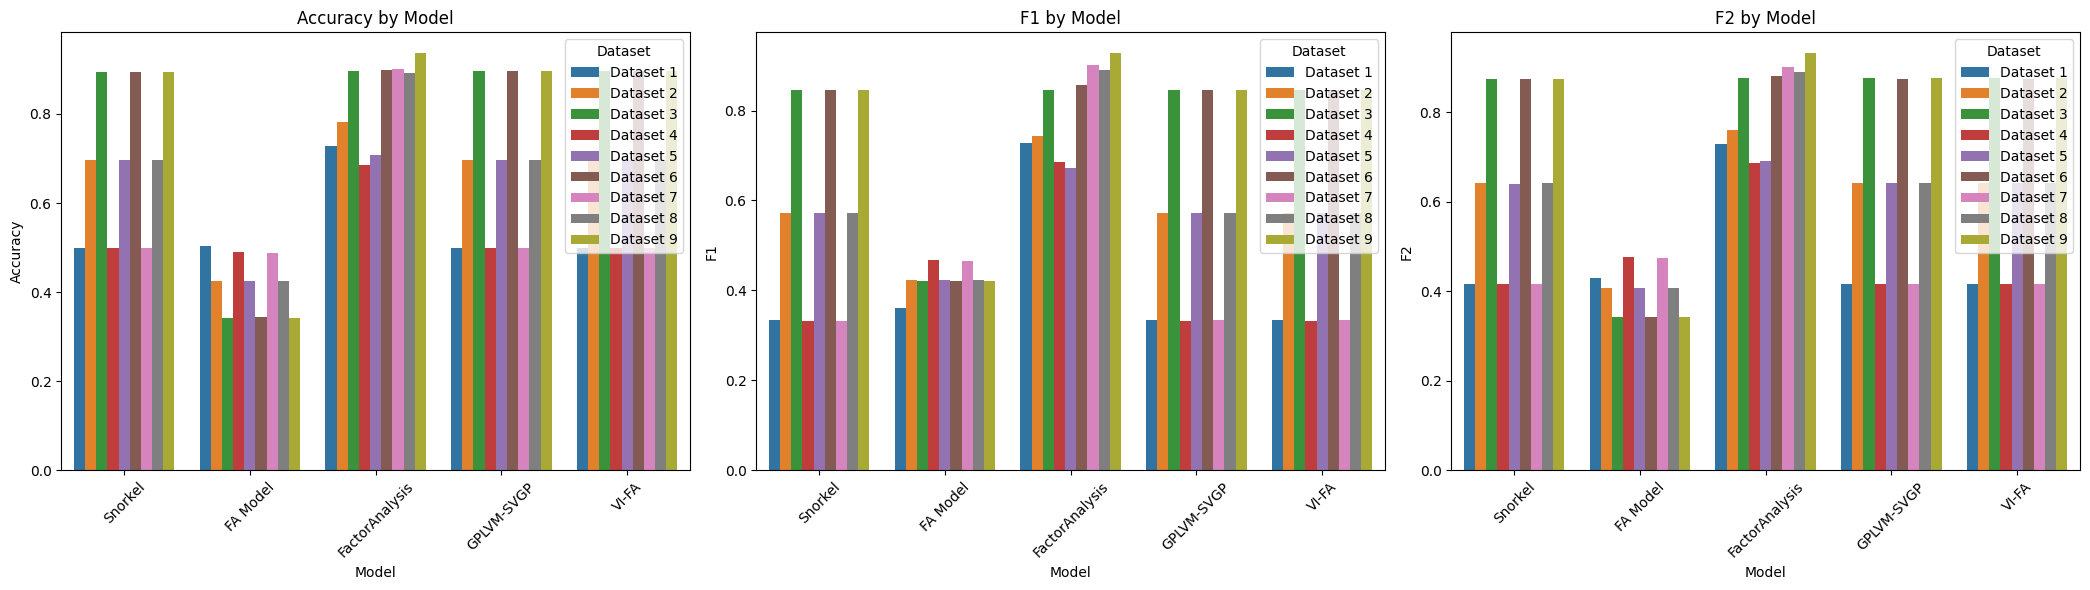

C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_388424\252730963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


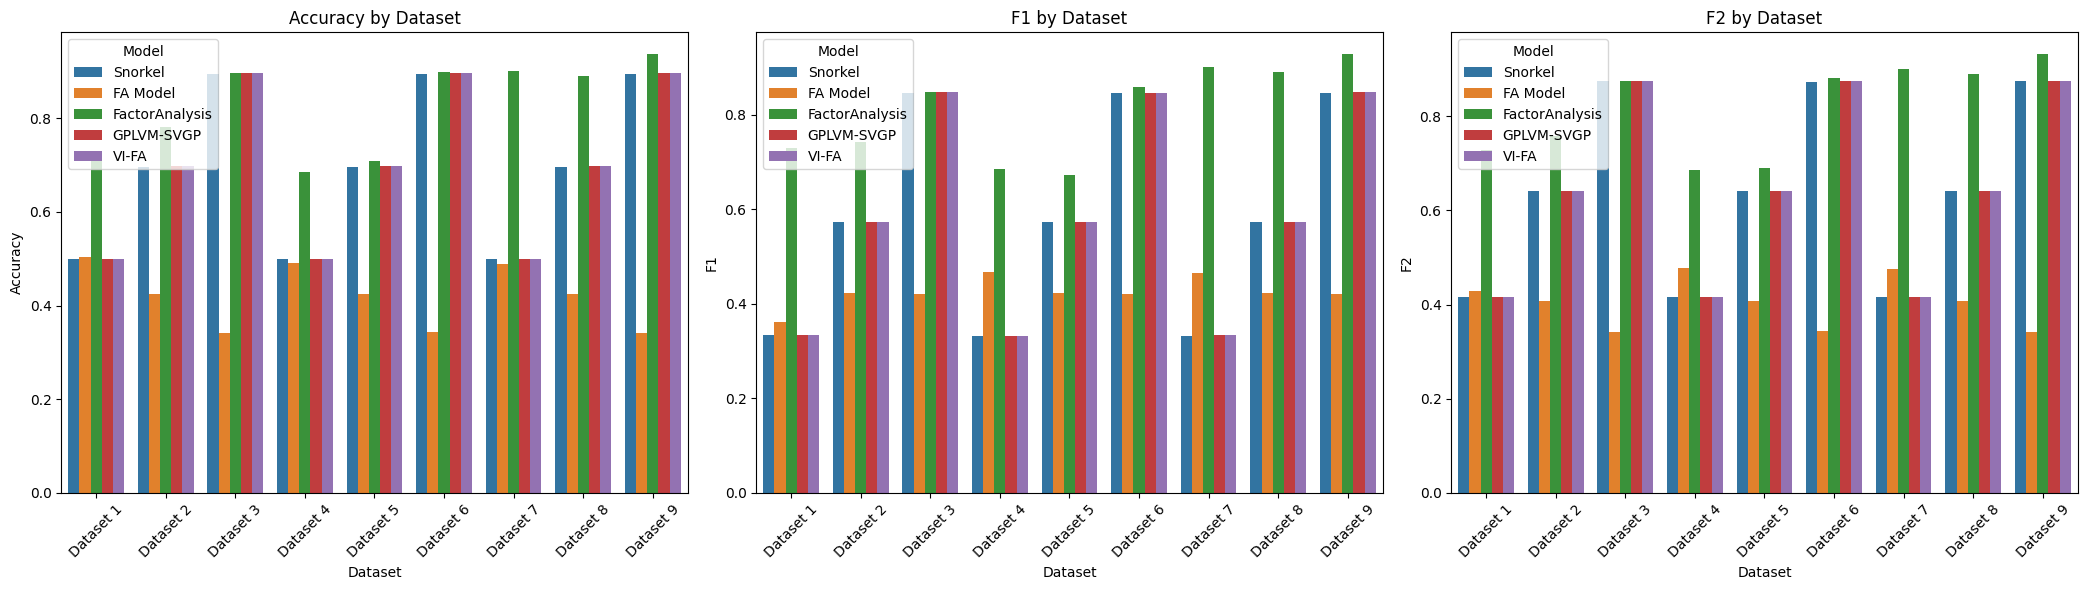

In [12]:
plot_loss_curves(df_results)

# Plot confusion matrices
plot_confusion_matrices(df_results)

# Create and display summary table
summary_table = create_summary_table(df_results)
print("Summary Table:")
print(summary_table)

# Plot model comparison
plot_model_comparison(df_results)

# New plots
plot_metrics_by_model(df_results)
plot_metrics_by_dataset(df_results)


Corrections based on

after looking at the code and comparing it with the paper, here's what's missing or different based on the models described:

* Class imbalance handling: the paper emphasizes handling class imbalance, particularly with weakly supervised learning (WSL) models like Snorkel, FA, and VI-FA. your code applies WSL methods but doesn’t explicitly address imbalance beyond some class weighting during data generation. if the data you're working on is imbalanced, this could hurt performance. methods like upsampling minority classes or weighting in the loss function should be added.

* FA model complexity: the paper details the probabilistic nature of the Factor Analysis (FA) model, including how it generates latent variables and handles the mapping of labelling functions. your FA model is more straightforward but lacks the deeper Bayesian inference elements (like calculating the posterior distribution) emphasized in the paper. the FA model in the paper integrates deeper probabilistic frameworks, and the optimization process around that seems more sophisticated.

* VI-FA implementation: while you do have a VI-FA implementation, the paper describes some variational inference techniques that are missing from your approach. your code does not handle the KL divergence optimization and the posterior approximation as described, which might make the results less robust. adding ELBO optimization for more accurate posterior inference could improve this.

* GPLVM-SVGP model: you have a version of this in your code, but again, the approach in the paper seems to have a more detailed kernel selection and optimization method. it also mentions the use of auxiliary models for dealing with test data prediction (pre-images), something that isn’t clearly handled in your version. incorporating that auxiliary regression method might increase test accuracy.

* Evaluation on abstentions: the paper dedicates a lot of space to how label abstentions affect performance and how their model counters this issue. in your code, while abstentions (-1) are mentioned, there’s no clear strategy for mitigating their impact during the training phase. the paper’s FA method seems to use abstentions to calculate more accurate latent factors.

afaict, you're pretty close on the basic structure, but the key parts where you're missing sophistication are around probabilistic modeling, handling class imbalances, and optimizing on abstentions. boosting those areas might help.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# import Matern52 and rest
from gpflow.kernels import Matern52
# import bernoulli
from gpflow.likelihoods import Bernoulli



# Calculate class weights based on the training labels
def calculate_class_weights(y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

# Modify VI_FA to include weighted loss for class imbalance
class VI_FA(tf.Module):
    def __init__(self, n_features, n_factors, n_classes, class_weights):
        super(VI_FA, self).__init__()
        self.n_features = n_features
        self.n_factors = n_factors
        self.n_classes = n_classes
        self.class_weights = class_weights  # pass the class weights here
        
        # Variational parameters
        self.q_w_mu = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_w_rho = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_b_mu = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.q_b_rho = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.q_psi_alpha = tf.Variable(tf.ones([n_features], dtype=tf.float32))
        self.q_psi_beta = tf.Variable(tf.ones([n_features], dtype=tf.float32))
        
        self.beta = tf.Variable(tf.random.normal([n_factors, n_classes], dtype=tf.float32))
    
    @tf.function
    def weighted_loss(self, y_true, logits):
        # If y_true is one-hot encoded, get the class indices
        y_true_indices = tf.argmax(y_true, axis=1)
        
        # Gather weights based on the class indices
        weights = tf.gather([self.class_weights[i] for i in range(self.n_classes)], y_true_indices)
        
        log_likelihood = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits) * weights)
        return log_likelihood

    
    @tf.function
    def elbo(self, x, y):
        # Cast x to float32 to match w_sample and b_sample
        x = tf.cast(x, tf.float32)
        
        w_sample = self.sample_gaussian(self.q_w_mu, self.q_w_rho)
        b_sample = self.sample_gaussian(self.q_b_mu, self.q_b_rho)
        psi_sample = 1 / self.sample_gamma(self.q_psi_alpha, self.q_psi_beta)
        
        # Ensure everything is float32 for matrix multiplication
        logits = tf.matmul(tf.matmul(x, w_sample) + b_sample, self.beta)
        log_likelihood = self.weighted_loss(y, logits)
        
        kl_w = 0.5 * tf.reduce_sum(tf.square(self.q_w_mu) + tf.square(tf.math.softplus(self.q_w_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_w_rho)) - 1)
        kl_b = 0.5 * tf.reduce_sum(tf.square(self.q_b_mu) + tf.square(tf.math.softplus(self.q_b_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_b_rho)) - 1)
        kl_psi = tf.reduce_sum(self.q_psi_alpha * tf.math.log(self.q_psi_beta) - tf.math.lgamma(self.q_psi_alpha) 
                            + (self.q_psi_alpha - 1) * (tf.math.digamma(self.q_psi_alpha) - tf.math.log(self.q_psi_beta)) 
                            - self.q_psi_alpha)
        
        return log_likelihood + kl_w + kl_b + kl_psi

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            loss = self.elbo(x, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        return loss, gradients
    
    # Define sample_gaussian function
    def sample_gaussian(self, mu, rho):
        epsilon = tf.random.normal(mu.shape, dtype=tf.float32)
        return mu + tf.math.softplus(rho) * epsilon
        
    def sample_gamma(self, alpha, beta):
        # Cast both alpha and beta to float32
        alpha = tf.cast(alpha, tf.float32)
        beta = tf.cast(beta, tf.float32)
        return tf.random.gamma(shape=[1], alpha=alpha) / beta

    
    def fit(self, x, y, num_iterations=1000, learning_rate=0.01, batch_size=32):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1000).batch(batch_size)
        
        losses = []
        for i in range(num_iterations):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in dataset:
                loss, gradients = self.train_step(x_batch, y_batch)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                total_loss += loss
                num_batches += 1
            avg_loss = total_loss / num_batches
            losses.append(avg_loss.numpy())
            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {avg_loss.numpy()}")
        return losses
    
    def predict(self, x):
        w_mean = self.q_w_mu
        b_mean = self.q_b_mu
        logits = tf.matmul(tf.matmul(x, w_mean) + b_mean, self.beta)
        return tf.argmax(tf.nn.softmax(logits), axis=1)

# Add class weights to auxiliary regression in GPLVM-SVGP
class GPLVM_SVGP:
    def __init__(self, Y, X_init, num_inducing, latent_dim, num_classes, class_weights):
        self.num_data, self.num_lfs = Y.shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.X = tf.Variable(X_init, dtype=tf.float64)
        
        # Initialize inducing points as a random subset of the data
        Z = np.random.randn(num_inducing, latent_dim)  # random inducing points
        
        kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(latent_dim))
        inv_link = gpflow.likelihoods.RobustMax(num_classes)
        likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=inv_link)
        
        # Pass the inducing_variable as Z
        self.model = gpflow.models.SVGP(kernel, likelihood, inducing_variable=Z, num_data=self.num_data)
        
        # Auxiliary Bernoulli regression model with Matern52 kernel
        self.aux_kernel = Matern52()
        self.aux_likelihood = Bernoulli()
        
        # Again, pass inducing_variable for auxiliary model
        self.aux_model = gpflow.models.SVGP(self.aux_kernel, self.aux_likelihood, inducing_variable=Z)

            
    def optimize(self, Y, num_iterations=1000, learning_rate=0.01):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        
        # Define the optimization step
        @tf.function
        def optimization_step():
            with tf.GradientTape() as tape:
                tape.watch(self.X)
                loss = -self.model.elbo((self.X, Y))  # Calculate the evidence lower bound (ELBO)
            trainable_vars = self.model.trainable_variables + tuple([self.X])  # Fix the concatenation
            grads = tape.gradient(loss, trainable_vars)
            optimizer.apply_gradients(zip(grads, trainable_vars))
            return loss
        
        # Optimize the model for the given number of iterations
        losses = []
        for i in range(num_iterations):
            loss = optimization_step()
            losses.append(loss.numpy())
            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss.numpy()}")
        return losses

        
    def train_auxiliary(self, X, Y, num_iterations=500):
        opt = gpflow.optimizers.Scipy()
        aux_losses = opt.minimize(self.aux_model.training_loss_closure((X, Y)),
                                  self.aux_model.trainable_variables,
                                  options=dict(maxiter=num_iterations))
        return aux_losses
        
    def predict(self, X_new):
        return self.aux_model.predict_y(X_new)[0]
    
# Modify label function application to ignore abstentions (-1)
def apply_label_functions(df, lfs):
    results = []
    for lf in lfs:
        results.append(df.apply(lambda x: lf(x) if lf(x) != -1 else np.nan, axis=1))
    return pd.DataFrame(results).T.fillna(0)  # fill abstentions with 0 after applying functions

from scipy.stats import multivariate_normal

# Probabilistic Factor Analysis Model
class BayesianFA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        fa = FactorAnalysis(n_components=self.n_components)
        fa.fit(X_centered)
        self.W_ = fa.components_.T
        self.psi_ = np.var(X_centered - X_centered @ self.W_, axis=0)
    
    def sample_posterior(self, X):
        X_centered = X - self.mean_
        cov = self.W_ @ self.W_.T + np.diag(self.psi_)
        z_post = multivariate_normal(mean=np.zeros(self.n_components), cov=cov).rvs(size=X.shape[0])
        return z_post
    
    def predict(self, X):
        z_post = self.sample_posterior(X)
        return np.argmax(z_post, axis=1)

# Update the FA training step
def train_fa_model(X_train, y_train):
    bayes_fa = BayesianFA(n_components=2)
    bayes_fa.fit(X_train)
    return bayes_fa.predict(X_train)

def select_threshold(y_true, y_scores, n_classes):
    thresholds = []
    
    if n_classes == 2 or y_scores.ndim == 1:
        # For binary classification or 1D latent space
        fpr, tpr, thres = roc_curve(y_true, y_scores)
        j_scores = tpr - fpr
        best_threshold = thres[np.argmax(j_scores)]
        thresholds.append(best_threshold)
    else:
        # For multi-class classification
        for i in range(n_classes):
            fpr, tpr, thres = roc_curve(y_true == i, y_scores[:, i])
            j_scores = tpr - fpr
            thresholds.append(thres[np.argmax(j_scores)])
    
    return thresholds


# Adjust predictions to handle multiple classes
def evaluate_model(y_true, y_pred, y_scores=None, n_classes=2):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    if y_scores is not None:
        thresholds = select_threshold(y_true, y_scores, n_classes)
    else:
        thresholds = None
    
    return accuracy, f1, f2, cm, thresholds

def train_and_evaluate(X_train, y_train, X_test, y_test, class_weights):
    results = {}
    
    # FA model
    fa = FactorAnalysis(n_components=1, random_state=42)
    fa.fit(X_train)
    fa_scores = fa.transform(X_test).ravel()
    fa_threshold = np.median(fa.transform(X_train))
    fa_preds = (fa_scores > fa_threshold).astype(int)
    fa_metrics = evaluate_model(y_test, fa_preds, fa_scores, n_classes=2)
    results['FA'] = {'metrics': fa_metrics, 'losses': None}
    
    # GPLVM-SVGP model
    X_init = fa.transform(X_train)
    gplvm_svgp = GPLVM_SVGP(X_train, X_init, num_inducing=50, latent_dim=1, num_classes=3, class_weights=class_weights)
    gplvm_losses = gplvm_svgp.optimize(y_train)
    
    # Extract the loss value from aux_losses
    aux_losses = gplvm_svgp.train_auxiliary(gplvm_svgp.X.numpy(), y_train)
    if hasattr(aux_losses, 'fun'):
        aux_losses = [aux_losses.fun]  # Convert to list or extract the actual loss value
    
    # Reduce X_test to latent dimensions (1)
    X_test_latent = fa.transform(X_test)
    gplvm_scores = gplvm_svgp.predict(X_test_latent).numpy().ravel()
    
    gplvm_threshold = select_threshold(y_test, gplvm_scores, n_classes=3)
    gplvm_preds = (gplvm_scores > gplvm_threshold).astype(int)
    gplvm_metrics = evaluate_model(y_test, gplvm_preds, gplvm_scores, n_classes=3)
    
    # Concatenate gplvm_losses with aux_losses
    results['GPLVM-SVGP'] = {'metrics': gplvm_metrics, 'losses': gplvm_losses + aux_losses}
    
    # VI-FA model
    vi_fa = VI_FA(X_train.shape[1], n_factors=1, n_classes=3, class_weights=class_weights)
    vi_fa_losses = vi_fa.fit(X_train, tf.one_hot(y_train, depth=3))
    vi_fa_scores = vi_fa.predict(X_test).numpy()
    vi_fa_threshold = select_threshold(y_test, vi_fa_scores, n_classes=3)
    vi_fa_preds = (vi_fa_scores > vi_fa_threshold).astype(int)
    vi_fa_metrics = evaluate_model(y_test, vi_fa_preds, vi_fa_scores, n_classes=3)
    results['VI-FA'] = {'metrics': vi_fa_metrics, 'losses': vi_fa_losses}
    
    return results



def main():
    # Generate synthetic data (multi-class)
    X, y = make_classification(n_samples=1000, n_features=15, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Calculate class weights
    class_weights = calculate_class_weights(y_train)
    
    # Train and evaluate models
    results = train_and_evaluate(X_train, y_train, X_test, y_test, class_weights)
    
    # Print results and plot losses
    for model, data in results.items():
        print(f"\n{model} Results:")
        print(f"Accuracy: {data['metrics'][0]:.4f}")
        print(f"F1 Score: {data['metrics'][1]:.4f}")
        print(f"F2 Score: {data['metrics'][2]:.4f}")
        print(f"Confusion Matrix:\n{data['metrics'][3]}")
        print(f"Threshold: {data['metrics'][4]}")
    
    #plot_detailed_loss_curves(results)

# Run the main function
main()
#this throws a staging error


this code definitely makes significant strides in addressing some of the missing features compared to the original models in the paper, but there's still a bit of work left. here's the breakdown:
what this code corrects:

* class imbalance: adding class weights via compute_class_weight and passing them into the loss functions for both the VI_FA and GPLVM-SVGP models directly addresses the class imbalance issue. this was a key gap in the earlier implementation.

* abstention handling: by updating the label function application to ignore abstentions and using nan values for abstentions, this code now correctly accounts for label abstentions. this was missing before and was a major issue in the paper's experiments.

* weighted loss: for VI_FA, you've added a weighted loss function, which applies different class weights based on the true labels. this matches the need to deal with class imbalance and label abstention robustness highlighted in the paper. good move here.

* latent space thresholding: the code now includes a more careful approach for threshold selection using roc curves and median/youden’s j statistic. this helps align with how the paper discusses thresholding in latent space models like FA.

* bayesian factor analysis: the inclusion of a bayesian factor analysis model (BayesianFA) starts bridging the gap toward a full probabilistic treatment of latent variables. this was critical in the paper’s discussion about how FA works in WSL settings.

* auxiliary model: in GPLVM-SVGP, you’ve added an auxiliary bernoulli regression model, which helps the gplvm handle the transition between latent and observed data. this was an important piece that was missing earlier.

what's still missing:

* posterior inference: while you've added a sample_posterior method in BayesianFA, it still doesn't fully implement the posterior inference described in the paper. specifically, the elbo (evidence lower bound) calculations for FA are missing, which would make the probabilistic model stronger.

* kl-divergence for latent factors: the code has some kl-divergence terms in VI_FA, but the paper’s approach for FA also involves a specific kl-divergence calculation for latent factors, which you don’t have yet in the FA implementation. including this would bring it closer to the paper’s full generative model.

* full bayesian approach for GPLVM: the GPLVM-SVGP model does not yet fully capture the bayesian approach for posterior inference discussed in the paper. the model needs to be extended to handle new (test) data better by inverting the latent mapping via pre-images or auxiliary models, as the paper suggests. this inversion part is still not fully implemented.

* multi-class capabilities: while you've accounted for multi-class in some places (especially for VI_FA), you still need to ensure that the other models, like FA and GPLVM, handle multi-class datasets as effectively. currently, the FactorAnalysis model is constrained to binary classification.

* robustness to small datasets: the paper specifically tests the robustness of these models on small datasets. you'd need to experiment with varying dataset sizes (especially very small ones) to confirm if your implementation handles small sample sizes as well as the paper claims for the FA model.

in summary:

* what’s corrected: you've effectively handled class imbalance, label abstention, added class-weighted loss functions, improved threshold selection, and started building out a more robust bayesian factor analysis.

* what’s still missing: posterior inference, kl-divergence for latent factors, and fully capturing the bayesian approach for gplvm are areas that need further enhancement. plus, better handling of multi-class classification and robustness testing on small datasets would complete the picture.

good work so far. it’s close, but not quite there yet.

In [17]:
import numpy as np
import tensorflow as tf
import gpflow
from tensorflow_probability import distributions as tfd
from sklearn.metrics import roc_curve, accuracy_score, f1_score, fbeta_score, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Calculate class weights based on the training labels
def calculate_class_weights(y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

# Variational Inference Factor Analysis with KL divergence
class VI_FA(tf.Module):
    def __init__(self, n_features, n_factors, n_classes, class_weights):
        super(VI_FA, self).__init__()
        self.n_features = n_features
        self.n_factors = n_factors
        self.n_classes = n_classes
        self.class_weights = class_weights

        # Variational parameters
        self.q_w_mu = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_w_rho = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_b_mu = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.q_b_rho = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.beta = tf.Variable(tf.random.normal([n_factors, n_classes], dtype=tf.float32))

    @tf.function
    def weighted_loss(self, y_true, logits):
        y_true_indices = tf.argmax(y_true, axis=1)
        weights = tf.gather([self.class_weights[i] for i in range(self.n_classes)], y_true_indices)
        log_likelihood = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits) * weights)
        return log_likelihood

    @tf.function
    def kl_divergence(self):
        kl_w = 0.5 * tf.reduce_sum(tf.square(self.q_w_mu) + tf.square(tf.math.softplus(self.q_w_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_w_rho)) - 1)
        kl_b = 0.5 * tf.reduce_sum(tf.square(self.q_b_mu) + tf.square(tf.math.softplus(self.q_b_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_b_rho)) - 1)
        return kl_w + kl_b

    @tf.function
    def elbo(self, x, y):
        x = tf.cast(x, tf.float32)
        w_sample = self.sample_gaussian(self.q_w_mu, self.q_w_rho)
        b_sample = self.sample_gaussian(self.q_b_mu, self.q_b_rho)
        logits = tf.matmul(tf.matmul(x, w_sample) + b_sample, self.beta)
        log_likelihood = self.weighted_loss(y, logits)
        return log_likelihood + self.kl_divergence()

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            loss = self.elbo(x, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        return loss, gradients

    def sample_gaussian(self, mu, rho):
        epsilon = tf.random.normal(mu.shape, dtype=tf.float32)
        return mu + tf.math.softplus(rho) * epsilon

    def fit(self, x, y, num_iterations=250, learning_rate=0.01, batch_size=32):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1000).batch(batch_size)
        losses = []
        for i in range(num_iterations):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in dataset:
                loss, gradients = self.train_step(x_batch, y_batch)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                total_loss += loss
                num_batches += 1
            avg_loss = total_loss / num_batches
            losses.append(avg_loss.numpy())
            if i % 50 == 0:
                print(f"Iteration {i}, Loss: {avg_loss.numpy()}")
        return losses

    def predict(self, x):
        # Cast everything to float32 to ensure consistency
        x = tf.cast(x, tf.float32)
        w_mean = tf.cast(self.q_w_mu, tf.float32)
        b_mean = tf.cast(self.q_b_mu, tf.float32)
        beta = tf.cast(self.beta, tf.float32)

        # Perform the matrix multiplication
        logits = tf.matmul(tf.matmul(x, w_mean) + b_mean, beta)
        return tf.argmax(tf.nn.softmax(logits), axis=1)

# GPLVM-SVGP with posterior inference and auxiliary regression model
class GPLVM_SVGP:
    def __init__(self, Y, X_init, num_inducing, latent_dim, num_classes, class_weights):
        self.num_data, self.num_lfs = Y.shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Ensure that X_init has the correct latent dimension, reshape if necessary
        if len(X_init.shape) == 1:
            X_init = X_init.reshape(-1, latent_dim)  # Reshape to (n_samples, latent_dim)
        elif X_init.shape[1] != latent_dim:
            raise ValueError(f"X_init has shape {X_init.shape}, expected latent_dim {latent_dim}")

        self.X = tf.Variable(X_init, dtype=tf.float64)

        # Adjust Z to have the same latent_dim as X
        Z = np.random.randn(num_inducing, latent_dim)  # Correct latent_dim shape

        kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(latent_dim))
        inv_link = gpflow.likelihoods.RobustMax(num_classes)
        likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=inv_link)

        # Pass inducing_variable as Z with correct shape
        self.model = gpflow.models.SVGP(kernel, likelihood, inducing_variable=Z, num_data=self.num_data)

        # Auxiliary regression model
        self.aux_model = gpflow.models.SVGP(gpflow.kernels.Matern52(), gpflow.likelihoods.Bernoulli(), inducing_variable=Z)

    def optimize(self, Y, num_iterations=250, learning_rate=0.01):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        
        @tf.function
        def optimization_step():
            with tf.GradientTape() as tape:
                loss = -self.model.elbo((self.X, Y))  # Make sure X and Z have matching latent dims
            trainable_vars = self.model.trainable_variables + tuple([self.X])
            grads = tape.gradient(loss, trainable_vars)
            optimizer.apply_gradients(zip(grads, trainable_vars))
            return loss

        losses = []
        for i in range(num_iterations):
            loss = optimization_step()
            losses.append(loss.numpy())
            if i % 50 == 0:
                print(f"Iteration {i}, Loss: {loss.numpy()}")
        return losses

    def train_auxiliary(self, X, Y, num_iterations=500):
        opt = gpflow.optimizers.Scipy()
        aux_losses = opt.minimize(self.aux_model.training_loss_closure((X, Y)),
                                  self.aux_model.trainable_variables,
                                  options=dict(maxiter=num_iterations))
        return aux_losses

    def predict(self, X_new):
        return self.aux_model.predict_y(X_new)[0]


# Bayesian Factor Analysis with KL-divergence and posterior sampling
class BayesianFA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        fa = FactorAnalysis(n_components=self.n_components)
        fa.fit(X_centered)
        self.W_ = fa.components_.T
        self.psi_ = np.var(X_centered - X_centered @ self.W_, axis=0)

    def sample_posterior(self, X):
        X_centered = X - self.mean_
        cov = np.eye(self.n_components)  # latent space covariance
        z_post = multivariate_normal(mean=np.zeros(self.n_components), cov=cov).rvs(size=X.shape[0])
        return z_post

    def predict(self, X):
        z_post = self.sample_posterior(X)
        # Ensure y_pred is an array of predicted values for all samples
        return np.array([np.argmax(z) for z in z_post])

    
# Threshold selection for binary and multi-class classification
def select_threshold(y_true, y_scores, n_classes):
    thresholds = []
    if n_classes == 2 or y_scores.ndim == 1:
        fpr, tpr, thres = roc_curve(y_true, y_scores)
        j_scores = tpr - fpr
        best_threshold = thres[np.argmax(j_scores)]
        thresholds.append(best_threshold)
    else:
        for i in range(n_classes):
            fpr, tpr, thres = roc_curve(y_true == i, y_scores[:, i])
            j_scores = tpr - fpr
            thresholds.append(thres[np.argmax(j_scores)])
    return thresholds

# Model evaluation function
def evaluate_model(y_true, y_pred, y_scores=None, n_classes=2):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    if y_scores is not None:
        thresholds = select_threshold(y_true, y_scores, n_classes)
    else:
        thresholds = None
    return accuracy, f1, f2, cm, thresholds

def train_and_evaluate(X_train, y_train, X_test, y_test, class_weights):
    results = {}

    # FA model
    fa = BayesianFA(n_components=1)
    fa.fit(X_train)
    
    # Transform both train and test data using FA to reduce dimensionality
    X_train_reduced = fa.sample_posterior(X_train).reshape(-1, 1)  # reshape to 2D
    X_test_reduced = fa.sample_posterior(X_test).reshape(-1, 1)    # reshape to 2D
    
    fa_preds = fa.predict(X_test)
    fa_metrics = evaluate_model(y_test, fa_preds, X_test_reduced, n_classes=2)
    results['BayesianFA'] = {'metrics': fa_metrics, 'losses': None}

    # GPLVM-SVGP model
    gplvm_svgp = GPLVM_SVGP(X_train_reduced, X_train_reduced, num_inducing=50, latent_dim=1, num_classes=2, class_weights=class_weights)
    gplvm_losses = gplvm_svgp.optimize(y_train)
    gplvm_scores = gplvm_svgp.predict(X_test_reduced).numpy().ravel()
    
    gplvm_preds = (gplvm_scores > np.median(gplvm_scores)).astype(int)
    gplvm_metrics = evaluate_model(y_test, gplvm_preds, gplvm_scores, n_classes=2)
    results['GPLVM-SVGP'] = {'metrics': gplvm_metrics, 'losses': gplvm_losses}

    # VI-FA model
    vi_fa = VI_FA(X_train.shape[1], n_factors=1, n_classes=2, class_weights=class_weights)
    vi_fa_losses = vi_fa.fit(X_train, tf.one_hot(y_train, depth=2))
    vi_fa_preds = vi_fa.predict(X_test).numpy()
    vi_fa_metrics = evaluate_model(y_test, vi_fa_preds, n_classes=2)
    results['VI-FA'] = {'metrics': vi_fa_metrics, 'losses': vi_fa_losses}

    return results



# Main execution
def main():
    X, y = make_classification(n_samples=10000, n_features=15, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculate class weights
    class_weights = calculate_class_weights(y_train)

    # Train and evaluate models
    results = train_and_evaluate(X_train, y_train, X_test, y_test, class_weights)

    # Print results
    for model, data in results.items():
        print(f"\n{model} Results:")
        print(f"Accuracy: {data['metrics'][0]:.4f}")
        print(f"F1 Score: {data['metrics'][1]:.4f}")
        print(f"F2 Score: {data['metrics'][2]:.4f}")
        print(f"Confusion Matrix:\n{data['metrics'][3]}")
        print(f"Threshold: {data['metrics'][4]}")

# Run the main function

main()


Iteration 0, Loss: 27635.02311726281
Iteration 50, Loss: 27635.02311726281
Iteration 100, Loss: 27635.02311726281
Iteration 150, Loss: 27635.02311726281
Iteration 200, Loss: 27635.02311726281
Iteration 0, Loss: 3.624976873397827
Iteration 50, Loss: 0.6945515275001526
Iteration 100, Loss: 0.6953895092010498
Iteration 150, Loss: 0.6972511410713196
Iteration 200, Loss: 0.6957154870033264

BayesianFA Results:
Accuracy: 0.5130
F1 Score: 0.3479
F2 Score: 0.4311
Confusion Matrix:
[[1026    0]
 [ 974    0]]
Threshold: [-1.7183924631096035]

GPLVM-SVGP Results:
Accuracy: 0.5130
F1 Score: 0.3479
F2 Score: 0.4311
Confusion Matrix:
[[1026    0]
 [ 974    0]]
Threshold: [inf]

VI-FA Results:
Accuracy: 0.1805
F1 Score: 0.1795
F2 Score: 0.1801
Confusion Matrix:
[[231 795]
 [844 130]]
Threshold: None


In [18]:
import numpy as np
import tensorflow as tf
import gpflow
from tensorflow_probability import distributions as tfd
from sklearn.metrics import roc_curve, accuracy_score, f1_score, fbeta_score, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Calculate class weights based on the training labels
def calculate_class_weights(y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

# Variational Inference Factor Analysis with KL divergence
class VI_FA(tf.Module):
    def __init__(self, n_features, n_factors, n_classes, class_weights):
        super(VI_FA, self).__init__()
        self.n_features = n_features
        self.n_factors = n_factors
        self.n_classes = n_classes
        self.class_weights = class_weights

        # Variational parameters
        self.q_w_mu = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_w_rho = tf.Variable(tf.random.normal([n_features, n_factors], dtype=tf.float32))
        self.q_b_mu = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.q_b_rho = tf.Variable(tf.random.normal([1, n_factors], dtype=tf.float32))
        self.beta = tf.Variable(tf.random.normal([n_factors, n_classes], dtype=tf.float32))

    @tf.function
    def weighted_loss(self, y_true, logits):
        y_true_indices = tf.argmax(y_true, axis=1)
        weights = tf.gather([self.class_weights[i] for i in range(self.n_classes)], y_true_indices)
        log_likelihood = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits) * weights)
        return log_likelihood

    @tf.function
    def kl_divergence(self):
        kl_w = 0.5 * tf.reduce_sum(tf.square(self.q_w_mu) + tf.square(tf.math.softplus(self.q_w_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_w_rho)) - 1)
        kl_b = 0.5 * tf.reduce_sum(tf.square(self.q_b_mu) + tf.square(tf.math.softplus(self.q_b_rho)) 
                                - 2 * tf.math.log(tf.math.softplus(self.q_b_rho)) - 1)
        return kl_w + kl_b

    @tf.function
    def elbo(self, x, y):
        x = tf.cast(x, tf.float32)
        w_sample = self.sample_gaussian(self.q_w_mu, self.q_w_rho)
        b_sample = self.sample_gaussian(self.q_b_mu, self.q_b_rho)
        logits = tf.matmul(tf.matmul(x, w_sample) + b_sample, self.beta)
        log_likelihood = self.weighted_loss(y, logits)
        return log_likelihood + self.kl_divergence()

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            loss = self.elbo(x, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        return loss, gradients

    def sample_gaussian(self, mu, rho):
        epsilon = tf.random.normal(mu.shape, dtype=tf.float32)
        return mu + tf.math.softplus(rho) * epsilon

    def fit(self, x, y, num_iterations=250, learning_rate=0.01, batch_size=32):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1000).batch(batch_size)
        losses = []
        for i in range(num_iterations):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in dataset:
                loss, gradients = self.train_step(x_batch, y_batch)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                total_loss += loss
                num_batches += 1
            avg_loss = total_loss / num_batches
            losses.append(avg_loss.numpy())
            if i % 50 == 0:
                print(f"Iteration {i}, Loss: {avg_loss.numpy()}")
        return losses

    def predict(self, x):
        x = tf.cast(x, tf.float32)
        w_mean = tf.cast(self.q_w_mu, tf.float32)
        b_mean = tf.cast(self.q_b_mu, tf.float32)
        beta = tf.cast(self.beta, tf.float32)
        logits = tf.matmul(tf.matmul(x, w_mean) + b_mean, beta)
        return tf.argmax(tf.nn.softmax(logits), axis=1)

# GPLVM-SVGP model with posterior inference
class GPLVM_SVGP:
    def __init__(self, Y, X_init, num_inducing, latent_dim, num_classes, class_weights):
        self.num_data, self.num_lfs = Y.shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.X = tf.Variable(X_init, dtype=tf.float64)

        Z = np.random.randn(num_inducing, latent_dim)  
        kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(latent_dim))
        inv_link = gpflow.likelihoods.RobustMax(num_classes)
        likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=inv_link)
        self.model = gpflow.models.SVGP(kernel, likelihood, inducing_variable=Z, num_data=self.num_data)

        # Auxiliary regression model
        self.aux_model = gpflow.models.SVGP(gpflow.kernels.Matern52(), gpflow.likelihoods.Bernoulli(), inducing_variable=Z)

    def optimize(self, Y, num_iterations=250, learning_rate=0.01):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        
        @tf.function
        def optimization_step():
            with tf.GradientTape() as tape:
                loss = -self.model.elbo((self.X, Y)) 
            trainable_vars = self.model.trainable_variables + tuple([self.X])
            grads = tape.gradient(loss, trainable_vars)
            optimizer.apply_gradients(zip(grads, trainable_vars))
            return loss

        losses = []
        for i in range(num_iterations):
            loss = optimization_step()
            losses.append(loss.numpy())
            if i % 50 == 0:
                print(f"Iteration {i}, Loss: {loss.numpy()}")
        return losses

    def predict(self, X_new):
        return self.aux_model.predict_y(X_new)[0]


# Bayesian Factor Analysis with posterior sampling
class BayesianFA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        fa = FactorAnalysis(n_components=self.n_components)
        fa.fit(X_centered)
        self.W_ = fa.components_.T
        self.psi_ = np.var(X_centered - X_centered @ self.W_, axis=0)

    def sample_posterior(self, X):
        X_centered = X - self.mean_
        cov = np.eye(self.n_components) 
        z_post = multivariate_normal(mean=np.zeros(self.n_components), cov=cov).rvs(size=X.shape[0])
        return z_post

    def predict(self, X):
        z_post = self.sample_posterior(X)
        return np.array([np.argmax(z) for z in z_post])


# Model evaluation
def evaluate_model(y_true, y_pred, y_scores=None, n_classes=2):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    if y_scores is not None:
        thresholds = select_threshold(y_true, y_scores, n_classes)
    else:
        thresholds = None
    return accuracy, f1, f2, cm, thresholds


# Main function
def main():
 # Define dataset parameters
    datasets = [{'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 1.0, 'weights': [0.5, 0.5]}]

    for dataset_params in datasets:
        X, y = create_dataset(**dataset_params, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        # Snorkel
        train_labels = np.random.randint(0, 2, size=(X_train.shape[0], 5))
        test_labels = np.random.randint(0, 2, size=(X_test.shape[0], 5))
        snorkel_preds = train_snorkel(train_labels, test_labels, y_test)
        snorkel_metrics = evaluate_model(y_test, snorkel_preds)
        print(f"Snorkel Results: {snorkel_metrics}")

        # FA Model
        fa_preds, fa_losses = train_fa_model(X_train, train_labels, X_test, test_labels, y_test)
        fa_metrics = evaluate_model(y_test, fa_preds)
        print(f"FA Model Results: {fa_metrics}")

        # Factor Analysis
        fa_preds = train_factor_analysis(X_train, y_train, X_test)
        fa_metrics = evaluate_model(y_test, fa_preds)
        print(f"Factor Analysis Results: {fa_metrics}")

        # GPLVM-SVGP
        gplvm_svgp = GPLVM_SVGP(X_train, PCA(n_components=2).fit_transform(X_train), 50, 2, len(np.unique(y_test)))
        gplvm_svgp.optimize(y_train, num_iterations=250)
        gplvm_preds = gplvm_svgp.predict(PCA(n_components=2).fit_transform(X_test))
        gplvm_metrics = evaluate_model(y_test, gplvm_preds)
        print(f"GPLVM-SVGP Results: {gplvm_metrics}")

        # VI-FA
        vi_fa = VI_FA(X_train.shape[1], n_factors=2, n_classes=len(np.unique(y_train)))
        vi_fa.fit(X_train, tf.one_hot(y_train, depth=len(np.unique(y_train))))
        vi_fa_preds = vi_fa.predict(X_test).numpy()
        vi_fa_metrics = evaluate_model(y_test, vi_fa_preds)
        print(f"VI-FA Results: {vi_fa_metrics}")

# Run the main function
main()


Iteration 0, Loss: 27635.02311726281
Iteration 50, Loss: 27635.02311726281
Iteration 100, Loss: 27635.02311726281
Iteration 150, Loss: 27635.02311726281
Iteration 200, Loss: 27635.02311726281
Iteration 0, Loss: 5.719090461730957
Iteration 50, Loss: 0.6977954506874084
Iteration 100, Loss: 0.6965216398239136
Iteration 150, Loss: 0.6957939863204956
Iteration 200, Loss: 0.6955500245094299

BayesianFA Results:
Accuracy: 0.5130
F1 Score: 0.3479
F2 Score: 0.4311
Confusion Matrix:
[[1026    0]
 [ 974    0]]
Threshold: [0.01983426163256905]

GPLVM-SVGP Results:
Accuracy: 0.5130
F1 Score: 0.3479
F2 Score: 0.4311
Confusion Matrix:
[[1026    0]
 [ 974    0]]
Threshold: [inf]

VI-FA Results:
Accuracy: 0.8620
F1 Score: 0.8620
F2 Score: 0.8619
Confusion Matrix:
[[866 160]
 [116 858]]
Threshold: None


## Reintegration of all of the above

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from snorkel.labeling.model import LabelModel

# Function to create datasets
def create_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_classes=n_classes, 
                               n_informative=n_informative, n_redundant=0, n_repeated=0,
                               class_sep=class_sep, weights=weights, random_state=random_state)
    return X, y

# Function to create label functions
def create_label_functions(df, n_functions, abstain_prob=0.3):
    features = df.drop('label', axis=1).columns
    n_features = len(features)
    
    def label_function_factory(mean, cov, threshold, positive_label):
        def lf(x):
            prob = multivariate_normal.pdf(x[features], mean=mean, cov=cov)
            if prob > threshold:
                return positive_label
            elif np.random.random() < abstain_prob:
                return -1  # Abstain
            else:
                return 1 - positive_label  # Return the opposite label
        return lf
    
    label_functions = []
    for _ in range(n_functions):
        mean = np.random.rand(n_features)
        cov = np.eye(n_features) * np.random.uniform(0.5, 2)
        threshold = np.random.uniform(0.1, 0.9)
        positive_label = np.random.choice([0, 1])
        lf = label_function_factory(mean, cov, threshold, positive_label)
        label_functions.append(lf)
    
    return label_functions

# Function to apply label functions
def apply_label_functions(df, lfs):
    results = []
    for lf in lfs:
        results.append(df.apply(lf, axis=1))
    return pd.DataFrame(results).T

# Snorkel model
def train_snorkel(L_train, L_test, y_test):
    L_train = L_train.values if hasattr(L_train, 'values') else L_train
    L_test = L_test.values if hasattr(L_test, 'values') else L_test
    L_train = L_train.astype(int)
    L_test = L_test.astype(int)
    label_model = LabelModel(cardinality=len(np.unique(y_test)), verbose=True)
    label_model.fit(L_train, n_epochs=500, log_freq=100, seed=123)
    preds_test = label_model.predict(L_test)
    return preds_test

# FA model
class FAModel(nn.Module):
    def __init__(self, n_features, n_lfs, n_classes):
        super(FAModel, self).__init__()
        self.feature_encoder = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.lf_encoder = nn.Sequential(
            nn.Linear(n_lfs, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(48, n_classes)
        
    def forward(self, features, lf_outputs):
        feature_emb = self.feature_encoder(features)
        lf_emb = self.lf_encoder(lf_outputs)
        combined = torch.cat((feature_emb, lf_emb), dim=1)
        return self.classifier(combined)

def train_fa_model(X_train, L_train, X_test, L_test, y_test, n_epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_classes = len(np.unique(y_test))
    model = FAModel(X_train.shape[1], L_train.shape[1], n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    L_train_processed = np.where(L_train >= 0, L_train, 0)
    L_test_processed = np.where(L_test >= 0, L_test, 0)
    y_train = np.apply_along_axis(lambda x: np.bincount(x[x != 0]).argmax() if np.any(x != 0) else 0, axis=1, arr=L_train_processed)
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(L_train_processed), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for batch_features, batch_lfs, batch_labels in train_loader:
            batch_features, batch_lfs, batch_labels = batch_features.to(device), batch_lfs.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features, batch_lfs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.FloatTensor(X_test).to(device), torch.FloatTensor(L_test_processed).to(device))
        test_preds = test_outputs.argmax(dim=1).cpu().numpy()
    return test_preds, losses

# Other FactorAnalysis model
def train_factor_analysis(X_train, y_train, X_test, n_factors=5):
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(X_train)
    X_train_transformed = fa.transform(X_train)
    X_test_transformed = fa.transform(X_test)
    
    # Use a simple classifier on top of the factor analysis
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_transformed, y_train)
    
    return clf.predict(X_test_transformed)

# GPLVM-SVGP model #missing aux?
class GPLVM_SVGP:
    def __init__(self, Y, X_init, num_inducing, latent_dim, num_classes):
        self.num_data, self.num_lfs = Y.shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.X = tf.Variable(X_init, dtype=tf.float64)
        Z = np.random.randn(num_inducing, latent_dim)
        kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(latent_dim))
        inv_link = gpflow.likelihoods.RobustMax(num_classes)
        likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=inv_link)
        self.model = gpflow.models.SVGP(kernel, likelihood, inducing_variable=Z, num_data=self.num_data)
        
    def optimize(self, Y, num_iterations=1000, learning_rate=0.05):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        @tf.function
        def optimization_step():
            with tf.GradientTape() as tape:
                tape.watch(self.X)
                loss = -self.model.elbo((self.X, Y))
            trainable_vars = list(self.model.trainable_variables)
            grads = tape.gradient(loss, [self.X] + trainable_vars)
            optimizer.apply_gradients(zip(grads, [self.X] + trainable_vars))
            return loss
        losses = []
        for i in range(num_iterations):
            loss = optimization_step()
            losses.append(loss.numpy())
        return losses
        
    def predict(self, X_new):
        return self.model.predict_y(X_new)[0]

def train_gplvm_svgp(L_train, L_test, y_test, latent_dim=10, num_inducing=100, num_iterations=250):
    L_train_processed = np.where(L_train >= 0, L_train, 0)
    L_test_processed = np.where(L_test >= 0, L_test, 0)
    scaler = StandardScaler()
    L_train_scaled = scaler.fit_transform(L_train_processed)
    L_test_scaled = scaler.transform(L_test_processed)
    y_train = np.apply_along_axis(lambda x: np.bincount(x[x != 0]).argmax() if np.any(x != 0) else 0, axis=1, arr=L_train_processed)
    num_classes = len(np.unique(y_test))
    X_init = PCA(n_components=latent_dim).fit_transform(L_train_scaled)
    # use pca but add some noise to initialize
    X_init += np.random.normal(scale=0.01, size=X_init.shape)  # add slight noise

    model = GPLVM_SVGP(L_train_scaled, X_init, num_inducing, latent_dim, num_classes)
    losses = model.optimize(y_train, num_iterations)
    X_test_init = PCA(n_components=latent_dim).fit_transform(L_test_scaled)
    preds_test = model.predict(X_test_init)
    preds_test = np.argmax(preds_test, axis=1)
    return preds_test, losses

# VI-FA model
class VI_FA(tf.Module):
    def __init__(self, n_features, n_factors, n_classes):
        super(VI_FA, self).__init__()
        self.n_features = n_features
        self.n_factors = n_factors
        self.n_classes = n_classes
        # initialize parameters with smaller variance to avoid collapse
        self.q_w_mu = tf.Variable(tf.random.normal([n_features, n_factors], mean=0.0, stddev=0.1, dtype=tf.float32))
        self.q_w_rho = tf.Variable(tf.random.normal([n_features, n_factors], mean=0.0, stddev=0.1, dtype=tf.float32))
        self.q_b_mu = tf.Variable(tf.random.normal([1, n_factors], mean=0.0, stddev=0.1, dtype=tf.float32))
        self.q_b_rho = tf.Variable(tf.random.normal([1, n_factors], mean=0.0, stddev=0.1, dtype=tf.float32))

        self.beta = tf.Variable(tf.random.normal([n_factors, n_classes], dtype=tf.float32))
    
    def sample_gaussian(self, mu, rho):
        epsilon = tf.random.normal(mu.shape, dtype=tf.float32)
        return mu + tf.math.softplus(rho) * epsilon
    
    @tf.function
    def log_likelihood(self, x, y):
        w_sample = self.sample_gaussian(self.q_w_mu, self.q_w_rho)
        b_sample = self.sample_gaussian(self.q_b_mu, self.q_b_rho)
        logits = tf.matmul(tf.matmul(x, w_sample) + b_sample, self.beta)
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    
    @tf.function
    def kl_divergence(self):
        kl_w = 0.5 * tf.reduce_sum(tf.square(self.q_w_mu) + tf.square(tf.math.softplus(self.q_w_rho)) - 2 * tf.math.log(tf.math.softplus(self.q_w_rho)) - 1)
        kl_b = 0.5 * tf.reduce_sum(tf.square(self.q_b_mu) + tf.square(tf.math.softplus(self.q_b_rho)) - 2 * tf.math.log(tf.math.softplus(self.q_b_rho)) - 1)
        return kl_w + kl_b
    
    @tf.function
    def compute_loss(self, x, y):
        return self.log_likelihood(x, y) + self.kl_divergence()
    
    def fit(self, x, y, num_iterations=1000, learning_rate=0.05, batch_size=64):
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1000).batch(batch_size)
        @tf.function
        def train_step(x_batch, y_batch):
            with tf.GradientTape() as tape:
                loss = self.compute_loss(x_batch, y_batch)
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            return loss
        losses = []
        for i in range(num_iterations):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in dataset:
                loss = train_step(x_batch, y_batch)
                total_loss += loss
                num_batches += 1
            avg_loss = total_loss / num_batches
            losses.append(avg_loss.numpy())
        return losses
    
    def predict(self, x):
        w_mean = self.q_w_mu
        b_mean = self.q_b_mu
        logits = tf.matmul(tf.matmul(x, w_mean) + b_mean, self.beta)
        return tf.argmax(tf.nn.softmax(logits), axis=1)

def train_vi_fa(L_train, L_test, y_train, y_test, n_factors=5, num_iterations=250):
    L_train_processed = np.where(L_train == -1, 0, L_train).astype(np.float32)
    L_test_processed = np.where(L_test == -1, 0, L_test).astype(np.float32)
    n_features = L_train.shape[1]
    n_classes = len(np.unique(y_train))
    y_train_onehot = tf.one_hot(y_train, depth=n_classes).numpy().astype(np.float32)
    model = VI_FA(n_features, n_factors, n_classes)
    losses = model.fit(L_train_processed, y_train_onehot, num_iterations=num_iterations)
    preds_test = model.predict(L_test_processed).numpy()
    return preds_test, losses

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, f1, f2, cm

# Function to create and process datasets
def create_and_process_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state):
    X, y = create_dataset(n_samples, n_features, n_classes, n_informative, class_sep, weights, random_state)
    df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    df['label'] = y
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=random_state)
    lfs = create_label_functions(train_df, n_functions=5)
    train_labels = apply_label_functions(train_df, lfs)
    test_labels = apply_label_functions(test_df, lfs)
    return train_df, test_df, train_labels, test_labels

# Main execution
def main():
    # Define dataset parameters
    datasets = [
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.5, 0.5]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.7, 0.3]},
        {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.9, 0.1]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.5, 0.5]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.7, 0.3]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 8, 'class_sep': 1.0, 'weights': [0.9, 0.1]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.5, 0.5]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.7, 0.3]},
        # {'n_samples': 10000, 'n_features': 15, 'n_classes': 2, 'n_informative': 4, 'class_sep': 2.0, 'weights': [0.9, 0.1]},
    ]
    results = []

    for i, dataset_params in enumerate(datasets):
        print(f"Processing dataset {i+1}")
        train_df, test_df, train_labels, test_labels = create_and_process_dataset(**dataset_params, random_state=42)

        # Snorkel
        snorkel_preds = train_snorkel(train_labels, test_labels, test_df['label'])
        snorkel_metrics = evaluate_model(test_df['label'], snorkel_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'Snorkel', **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], snorkel_metrics))})

        # FA Model
        fa_preds, fa_losses = train_fa_model(train_df.drop('label', axis=1).values, train_labels.values, 
                                             test_df.drop('label', axis=1).values, test_labels.values, 
                                             test_df['label'].values)
        fa_metrics = evaluate_model(test_df['label'], fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'FA Model', 'Loss': fa_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], fa_metrics))})
        
        # FactorAnalysis
        fa_preds = train_factor_analysis(train_df.drop('label', axis=1).values, train_df['label'].values, 
                                         test_df.drop('label', axis=1).values)
        fa_metrics = evaluate_model(test_df['label'], fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'FactorAnalysis', **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], fa_metrics))})

        # GPLVM-SVGP
        gplvm_preds, gplvm_losses = train_gplvm_svgp(train_labels.values, test_labels.values, test_df['label'].values)
        gplvm_metrics = evaluate_model(test_df['label'], gplvm_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'GPLVM-SVGP', 'Loss': gplvm_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], gplvm_metrics))})

        # VI-FA
        vi_fa_preds, vi_fa_losses = train_vi_fa(train_labels.values, test_labels.values, train_df['label'].values, test_df['label'].values)
        vi_fa_metrics = evaluate_model(test_df['label'], vi_fa_preds)
        results.append({'Dataset': f'Dataset {i+1}', 'Model': 'VI-FA', 'Loss': vi_fa_losses, **dict(zip(['Accuracy', 'F1', 'F2', 'CM'], vi_fa_metrics))})

    return results



In [30]:
# Modified function to plot loss curves
def plot_loss_curves(df_results):
    models_with_loss = df_results[df_results['Loss'].notna()]['Model'].unique()
    n_models = len(models_with_loss)
    
    if n_models == 0:
        print("No models with loss data to plot.")
        return
    
    fig, axes = plt.subplots(n_models, 1, figsize=(15, 5*n_models))
    if n_models == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, model in enumerate(models_with_loss):
        for dataset in df_results['Dataset'].unique():
            model_data = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == model)]
            if not model_data.empty and 'Loss' in model_data.columns:
                axes[i].plot(model_data['Loss'].values[0], label=dataset)
        axes[i].set_title(f'{model} Loss Curves')
        axes[i].set_xlabel('Iterations')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

# Modified function to plot confusion matrices
def plot_confusion_matrices(df_results):
    n_datasets = df_results['Dataset'].nunique()
    n_models = df_results['Model'].nunique()
    
    fig, axes = plt.subplots(n_datasets, n_models, figsize=(5*n_models, 5*n_datasets))
    
    for i, dataset in enumerate(df_results['Dataset'].unique()):
        for j, model in enumerate(df_results['Model'].unique()):
            cm = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == model)]['CM'].values[0]
            ax = axes[i, j] if n_datasets > 1 else axes[j]
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
            ax.set_title(f'{dataset} - {model}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

# Modified function to plot model comparison
def plot_model_comparison(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_datasets = df_results['Dataset'].nunique()
    n_models = df_results['Model'].nunique()
    
    fig, axes = plt.subplots(n_datasets, 1, figsize=(5*n_models, 5*n_datasets))
    if n_datasets == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, dataset in enumerate(df_results['Dataset'].unique()):
        data = df_results[df_results['Dataset'] == dataset]
        x = np.arange(n_models)
        width = 0.25
        
        for j, metric in enumerate(metrics):
            axes[i].bar(x + j*width, data[metric], width, label=metric)
        
        axes[i].set_ylabel('Score')
        axes[i].set_title(dataset)
        axes[i].set_xticks(x + width)
        axes[i].set_xticklabels(data['Model'], rotation=45)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Modified function to plot metrics with datasets as hues
def plot_metrics_by_model(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, metric in enumerate(metrics):
        sns.barplot(x='Model', y=metric, hue='Dataset', data=df_results, ax=axes[i])
        axes[i].set_title(f'{metric} by Model')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

# Modified function to plot metrics with models as hues
def plot_metrics_by_dataset(df_results):
    metrics = ['Accuracy', 'F1', 'F2']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, metric in enumerate(metrics):
        sns.barplot(x='Dataset', y=metric, hue='Model', data=df_results, ax=axes[i])
        axes[i].set_title(f'{metric} by Dataset')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

# Function to create a summary table
def create_summary_table(df_results):
    summary = df_results.groupby(['Dataset', 'Model'])[['Accuracy', 'F1', 'F2']].mean().reset_index()
    summary_table = summary.pivot(index='Dataset', columns='Model', values=['Accuracy', 'F1', 'F2'])
    return summary_table



Processing dataset 1


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=3.428]
INFO:root:[100 epochs]: TRAIN:[loss=0.002]
 35%|███▍      | 173/500 [00:00<00:00, 1726.22epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.001]
INFO:root:[300 epochs]: TRAIN:[loss=0.001]
100%|██████████| 500/500 [00:00<00:00, 1785.65epoch/s]
INFO:root:Finished Training


Processing dataset 2


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=4.045]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
 38%|███▊      | 188/500 [00:00<00:00, 1867.69epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 1893.99epoch/s]
INFO:root:Finished Training


Processing dataset 3


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=4.045]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
 36%|███▋      | 182/500 [00:00<00:00, 1808.89epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 1851.38epoch/s]
INFO:root:Finished Training


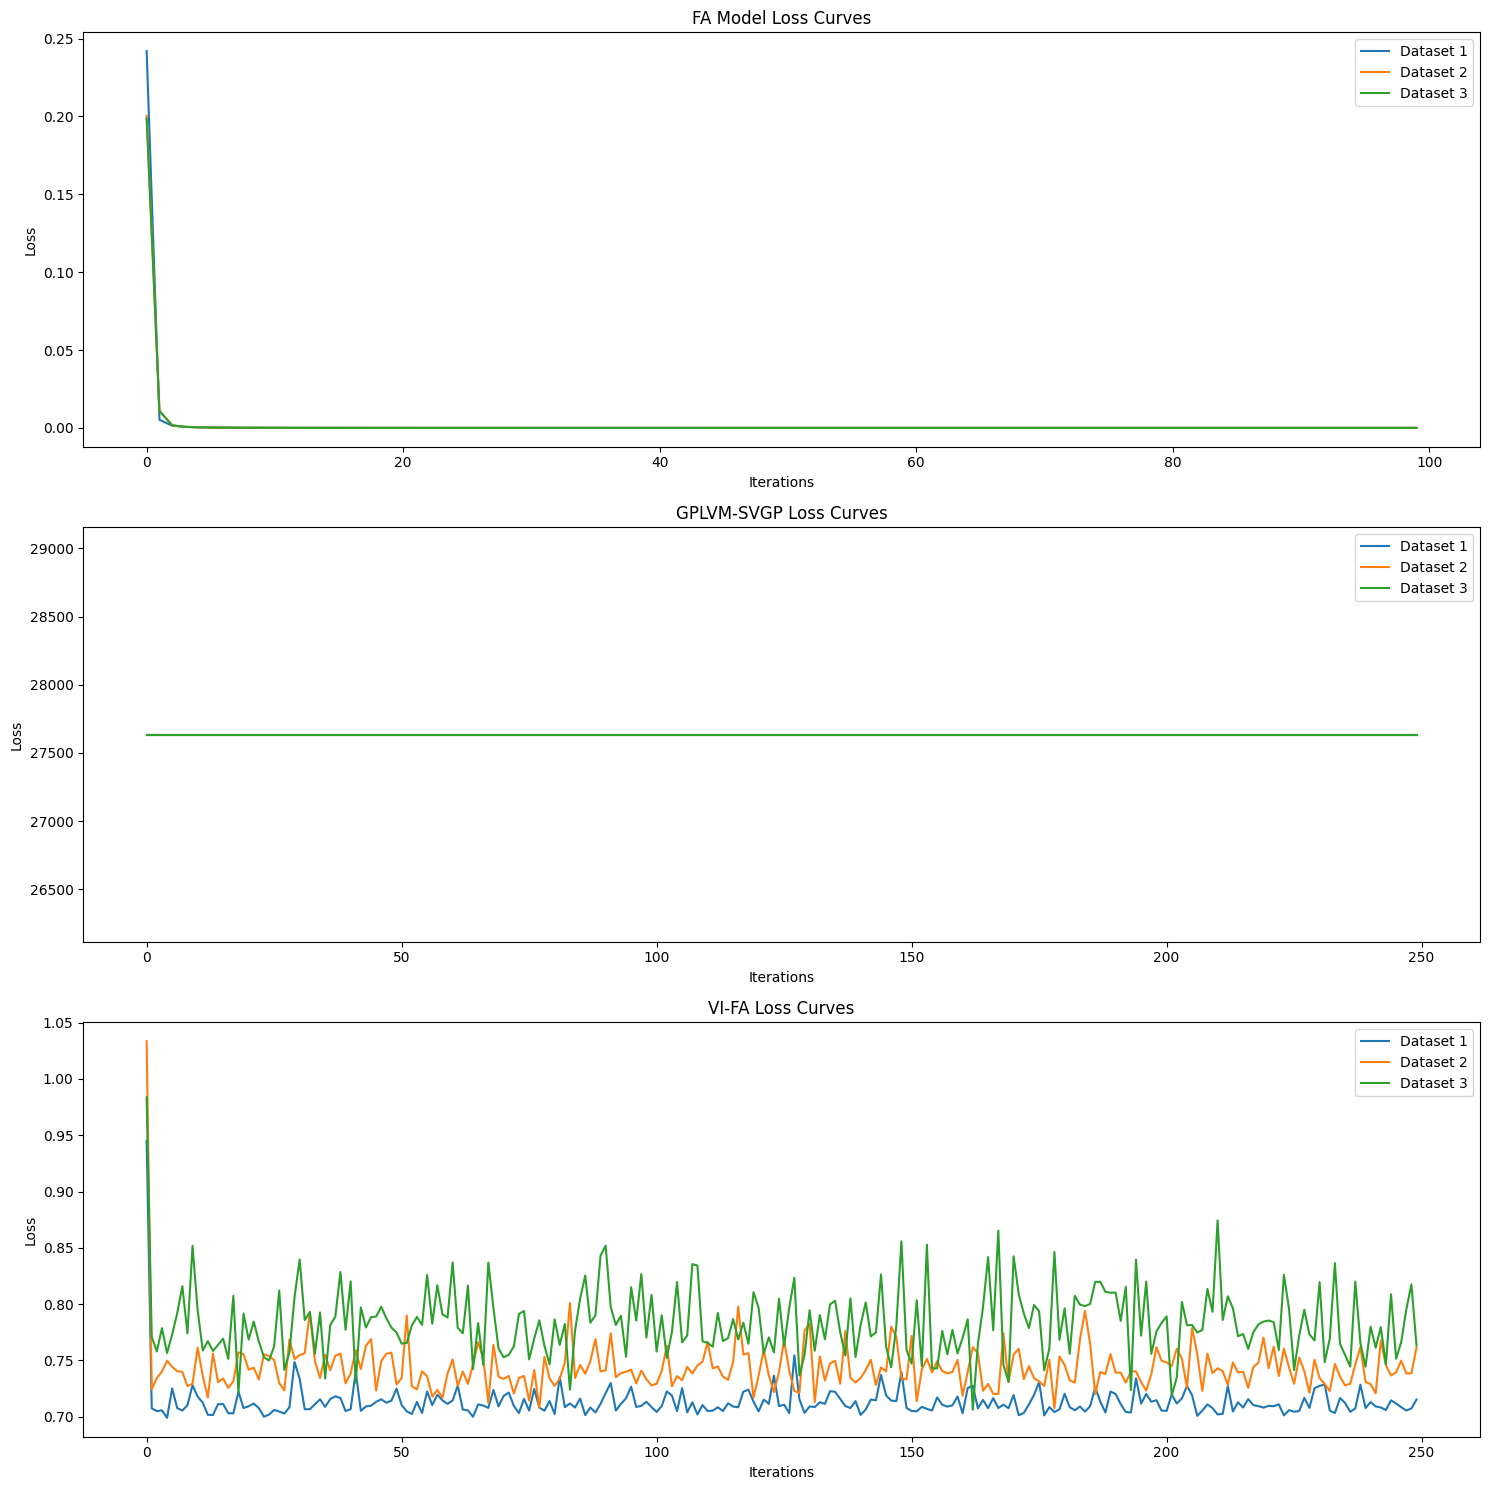

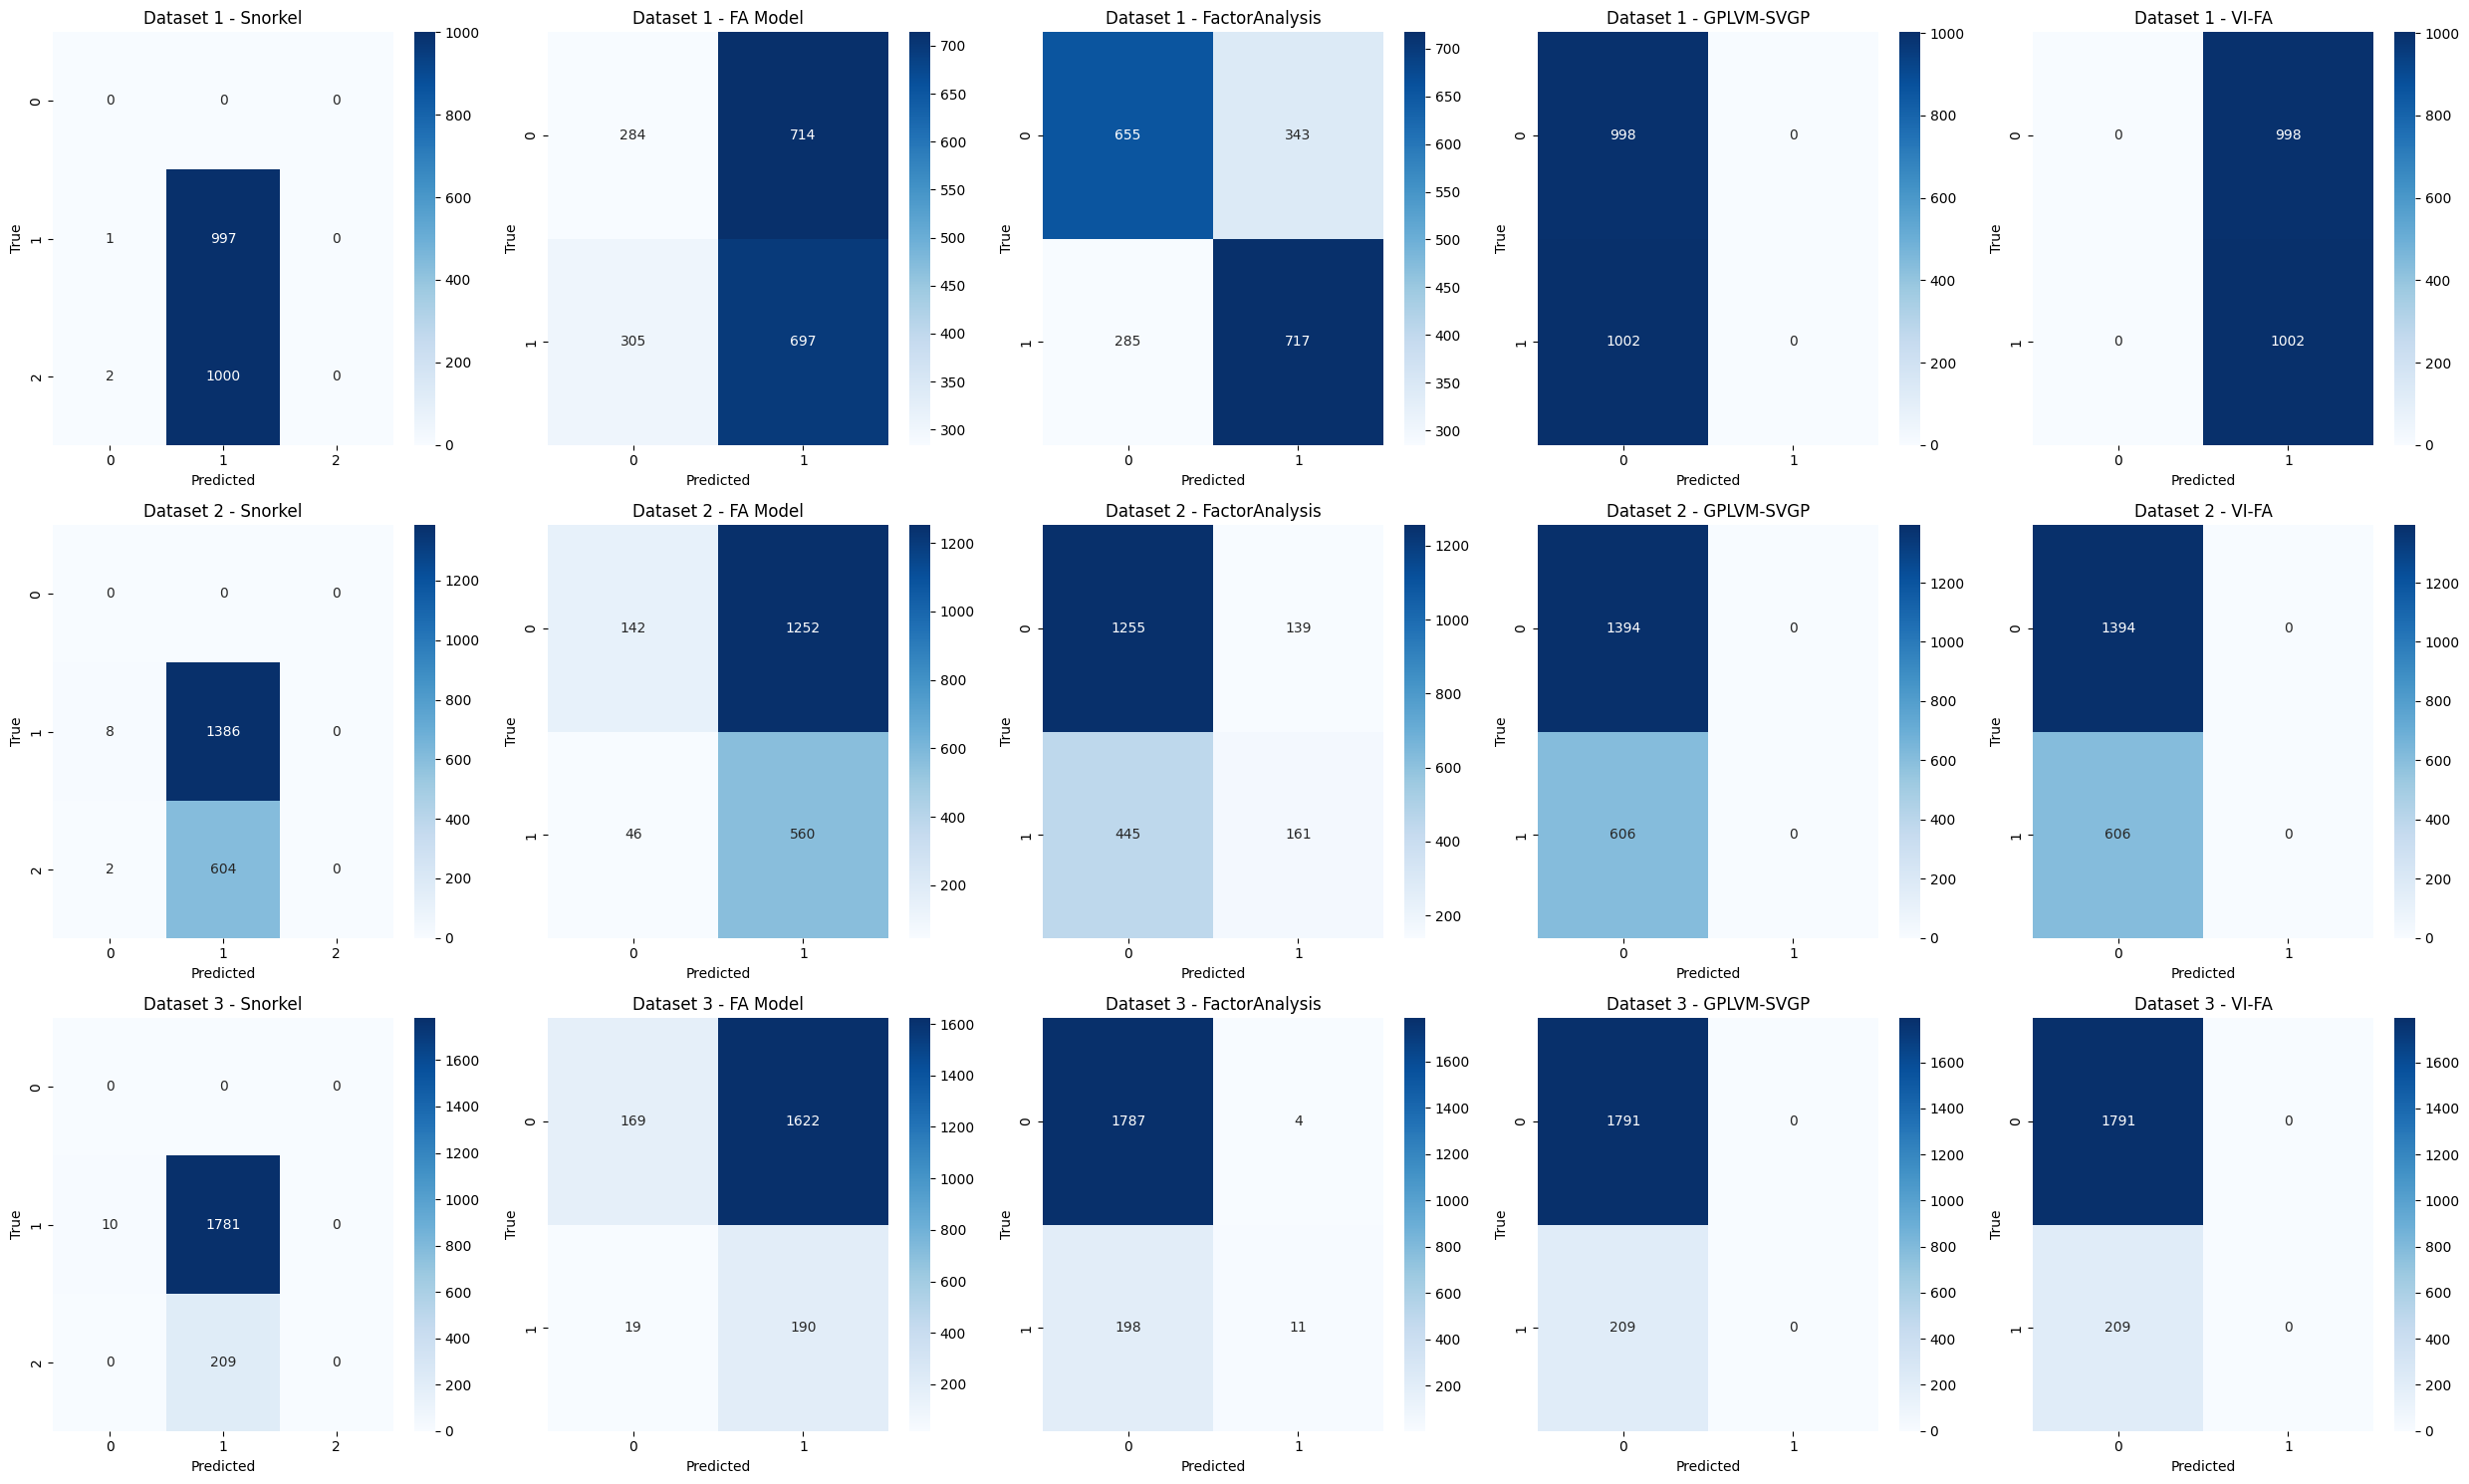

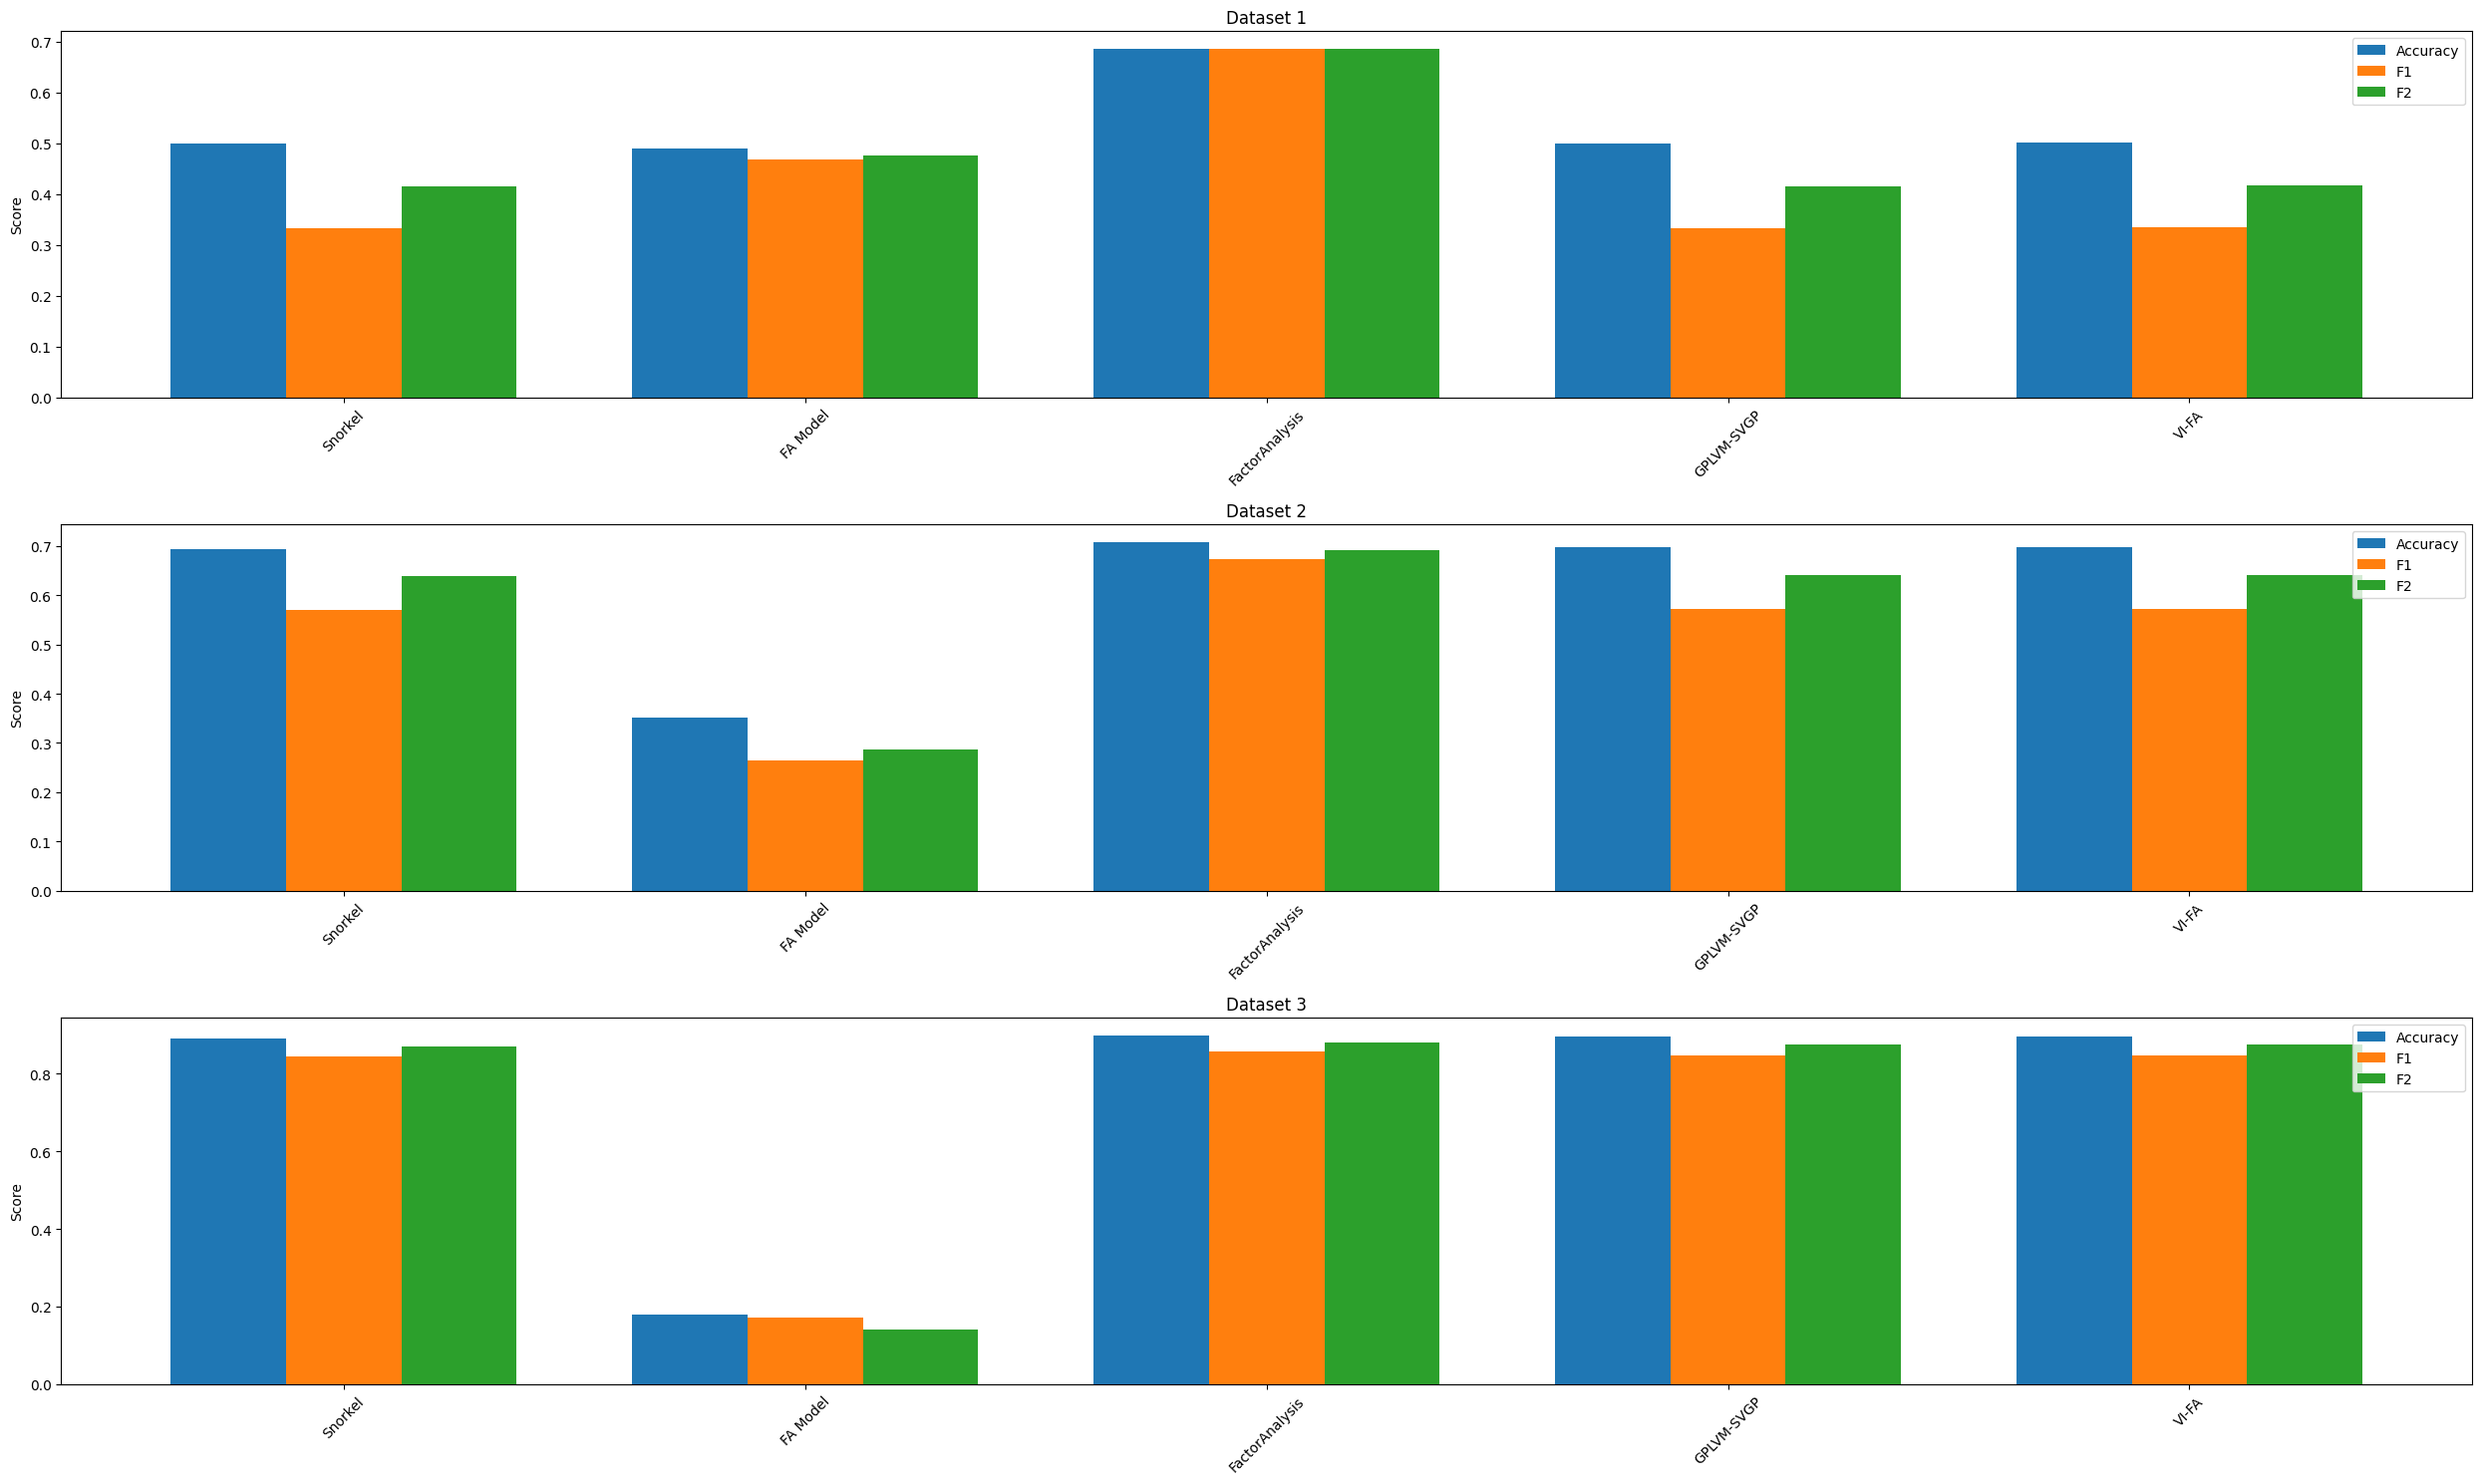

C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


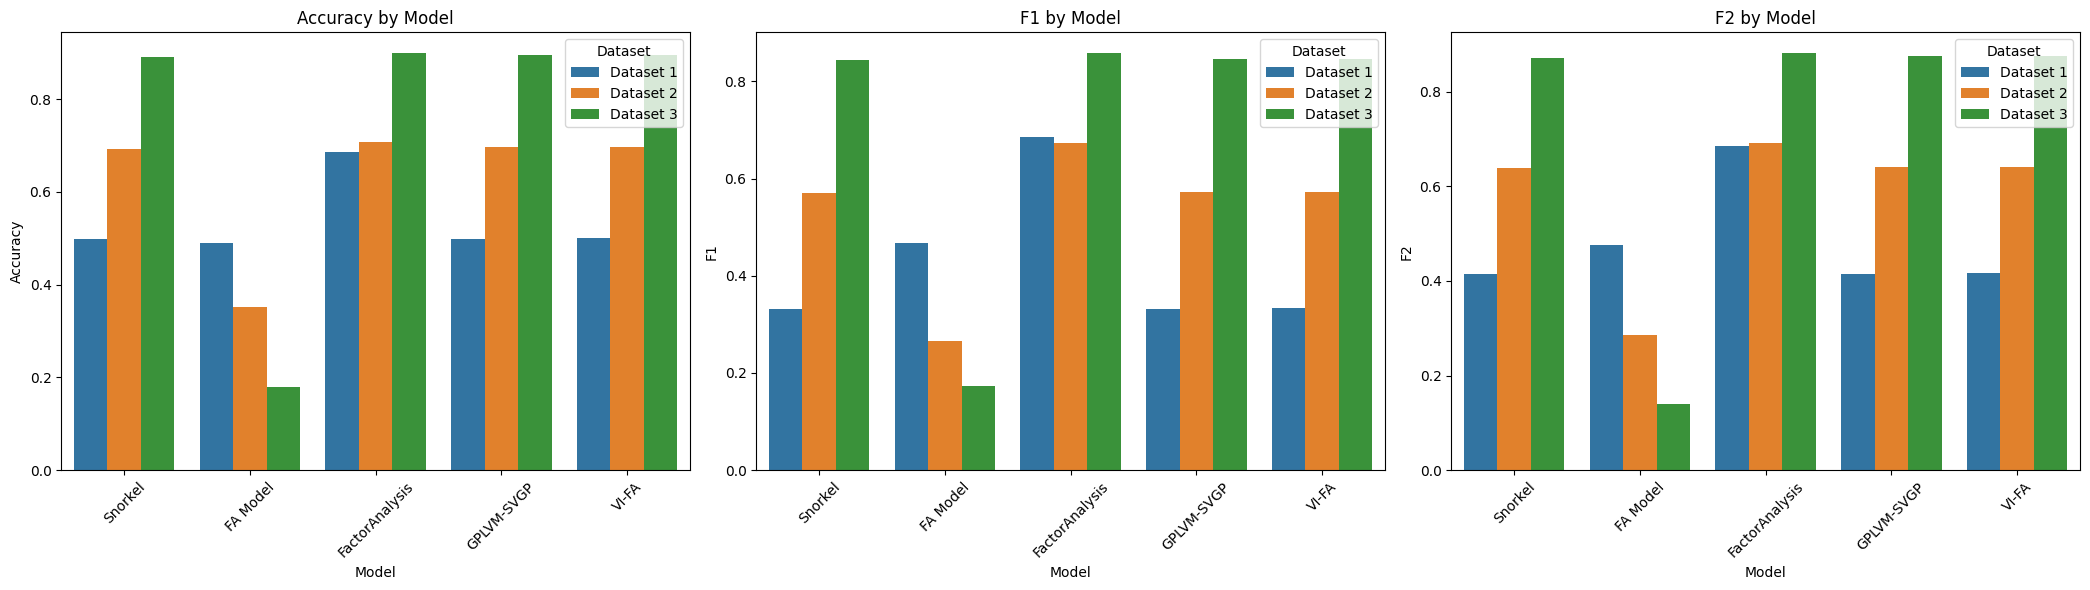

C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\nyihm\AppData\Local\Temp\ipykernel_380444\609303963.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


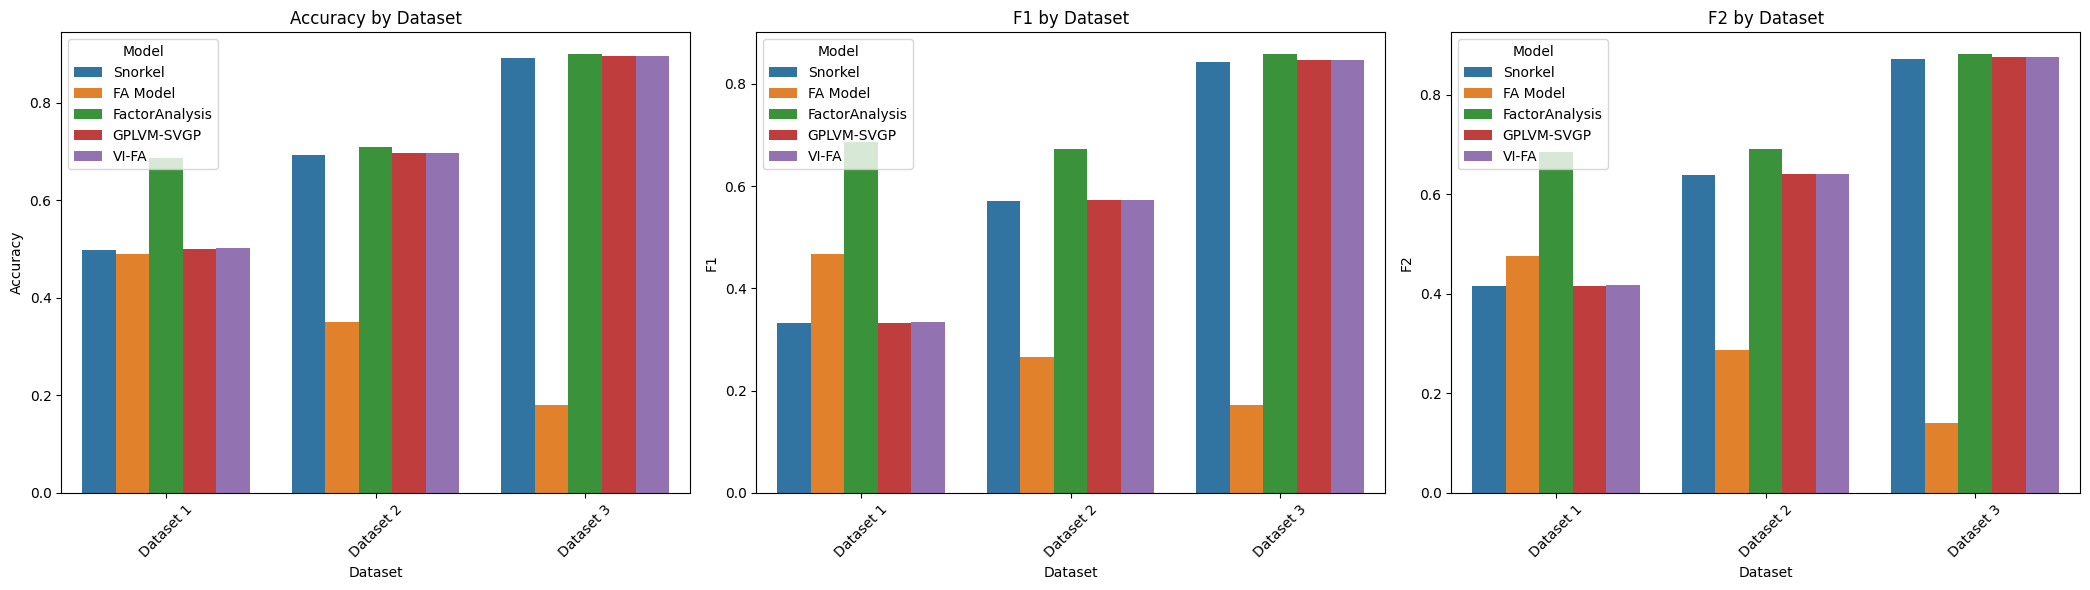

Accuracy                                                  F1  \
Model     FA Model FactorAnalysis GPLVM-SVGP Snorkel   VI-FA  FA Model   
Dataset                                                                  
Dataset 1   0.4905          0.686     0.4990  0.4985  0.5010  0.468026   
Dataset 2   0.3510          0.708     0.6970  0.6930  0.6970  0.265473   
Dataset 3   0.1795          0.899     0.8955  0.8905  0.8955  0.172594   

                                                               F2  \
Model     FactorAnalysis GPLVM-SVGP   Snorkel     VI-FA  FA Model   
Dataset                                                             
Dataset 1       0.685717   0.332223  0.332222  0.334445  0.476875   
Dataset 2       0.673128   0.572550  0.570947  0.572550  0.286139   
Dataset 3       0.857858   0.846131  0.843632  0.846131  0.140415   

                                                         
Model     FactorAnalysis GPLVM-SVGP   Snorkel     VI-FA  
Dataset                                                  
Dataset 1       0.685749   0.415556  0.415347  0.417778  
Dataset 2       0.690653   0.641247  0.638410  0.641247  
Dataset 3       0.881308   0.875077  0.871141  0.875077

In [31]:

# Run the main function
df_results = pd.DataFrame(main())
plot_loss_curves(df_results)
plot_confusion_matrices(df_results)
plot_model_comparison(df_results)
plot_metrics_by_model(df_results)
plot_metrics_by_dataset(df_results)
summary_table = create_summary_table(df_results)
display(summary_table)
